## Описание проекта "Предсказание количества заказов".

Требуется построить модель для предсказания заказов такси в аэропортах на горизонте следующего часа, чтобы привлекать больше водителей в периоды пиковой нагрузки. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

Работу над проектом будем осуществлять в следующем порядке:

### Этап 1. Импорт библиотек, считывание и первичный анализ данных:

<a href='#1.1'>1.1. Импорт библиотек, считывание и первичный анализ данных.</a> 

### Этап 2. Анализ данных, подготовка новых признаков:

<a href='#2.1'>2.1. Анализ данных.</a>


<a href='#2.2'>2.1. Подготовка новых признаков.</a>

### Этап 3. Обучение и тестирование моделей, подбор гиперпараметров:

<a href='#3.1'>3.1. LinearRegression.</a>

<a href='#3.2'>3.2. CatBoost.</a>

<a href='#3.3'>3.3. LightGBM.</a>

<a href='#3.4'>3.4. RandomForest.</a>

<a id='1.1'></a> 
# Этап 1. Импорт библиотек, считывание и первичный анализ данных.

Иморитриуем нужные библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import parallel_backend

Считаем набор данных. Чтобы дата из набора данных была считана как дата, а не как object, поле с датой передадим как аргумент параметру parse_dates. Также дата нужна нам как индекс, поэтому это поле передадим как аргумент параметру index_col.

In [2]:
df = pd.read_csv('taxi.csv', parse_dates = ['datetime'], index_col = 'datetime')

Для первичного анализа набора данных напишем функцию, принимающую на вход набор данных и выводящую о нём основную интересующую нас информацию: первые 10 строк, общую информацию о наборе данных, размер набора данных, количество дубликатов и пропусков, а также частота встречаемости уникальных значений каждого признака.

In [3]:
def df_info(df):
    print('Первые 10 строк DF')
    display(df.head(10))
    print('Общая информация о DF')
    display(df.info())
    print('Размер df:', df.shape)
    print()
    print('Пропуски в df')
    display(df.isna().sum())
    print('Количество дубликатов в df:', df.duplicated().sum())
    print()
    for col in df.columns:
        print('*** Поле', col + ': уникальные значения ***')
        display(df[col].value_counts())
df_info(df)

Первые 10 строк DF


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Общая информация о DF
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Размер df: (26496, 1)

Пропуски в df


num_orders    0
dtype: int64

Количество дубликатов в df: 26415

*** Поле num_orders: уникальные значения ***


9     1373
11    1365
12    1317
10    1316
8     1253
      ... 
67       1
99       1
90       1
87       1
95       1
Name: num_orders, Length: 81, dtype: int64

# Вывод по этапу 1.

На данном этапе были импортированы необходимые библиотеки, а также считан и проанализирован первичный набор данных.

Набор данных представляет собой временной ряд, который описывает количество заказов такси с 2018-03-01 по 2018-08-31 с десятиминутным интервалом. 

Пропущенные и аномальные значения, а также дубликаты не выявлены.

# 2. Анализ данных, подготовка новых признаков.

<a id='2.1'></a> 
## Этап 2.1. Анализ данных.

На данном этапе проанализируем данные и подготовим их к моделированию.

Для начала проверим, упорядочены ли индексы (даты) в порядке возрастания. Используем метод is_monotonic, применим его к индексам набора данных.

In [4]:
print(df.index.is_monotonic)

True


Видим, что индексы (даты) упорядочены по возрастанию.

Далее необходимо сделать ресемплирование данных из минут в часы. Для этого используем функцию resample, параметром укажем значение "1H", что соответствует 1 часу, в качестве агрегирующей функции при группировки объектов внутри интервала укажем sum, так как в 1 час должны суммарно попать все поездки за 6 интервалов по 10 минут.

In [5]:
df = df.resample('1H').sum()

Визуализируем временной ряд.

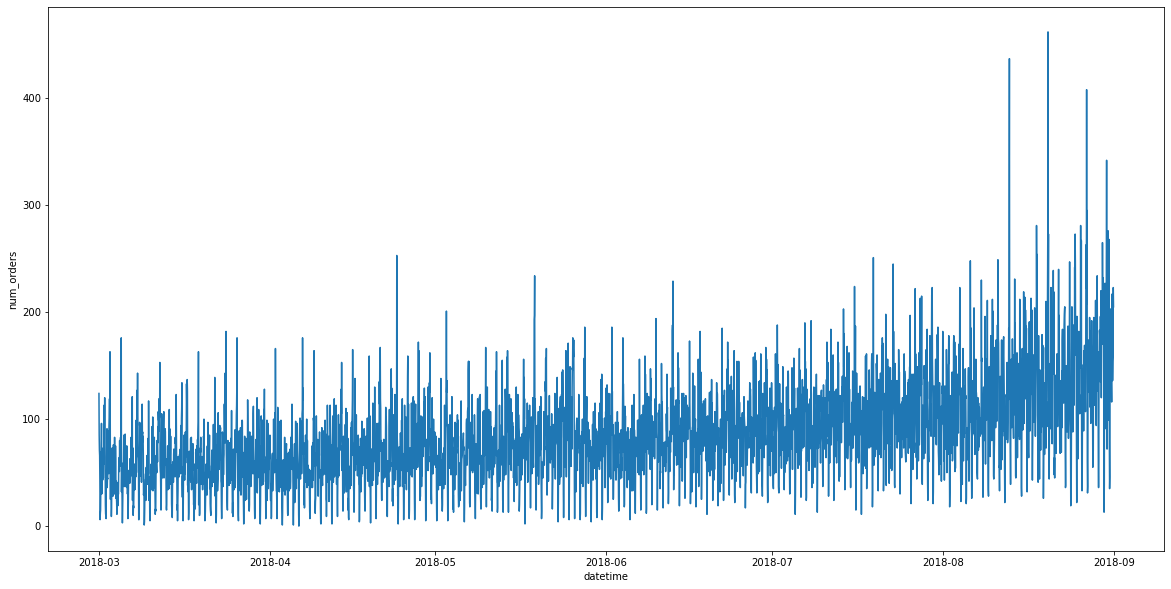

In [6]:
plt.figure(figsize=(20,10))
sns.lineplot(data = df, x=df.index, y='num_orders');

Видим, что внутр временного ряда количество поездок сильно колеблется.

Попытаемся сгалидт колебания с помощью метода скользящего среднего.

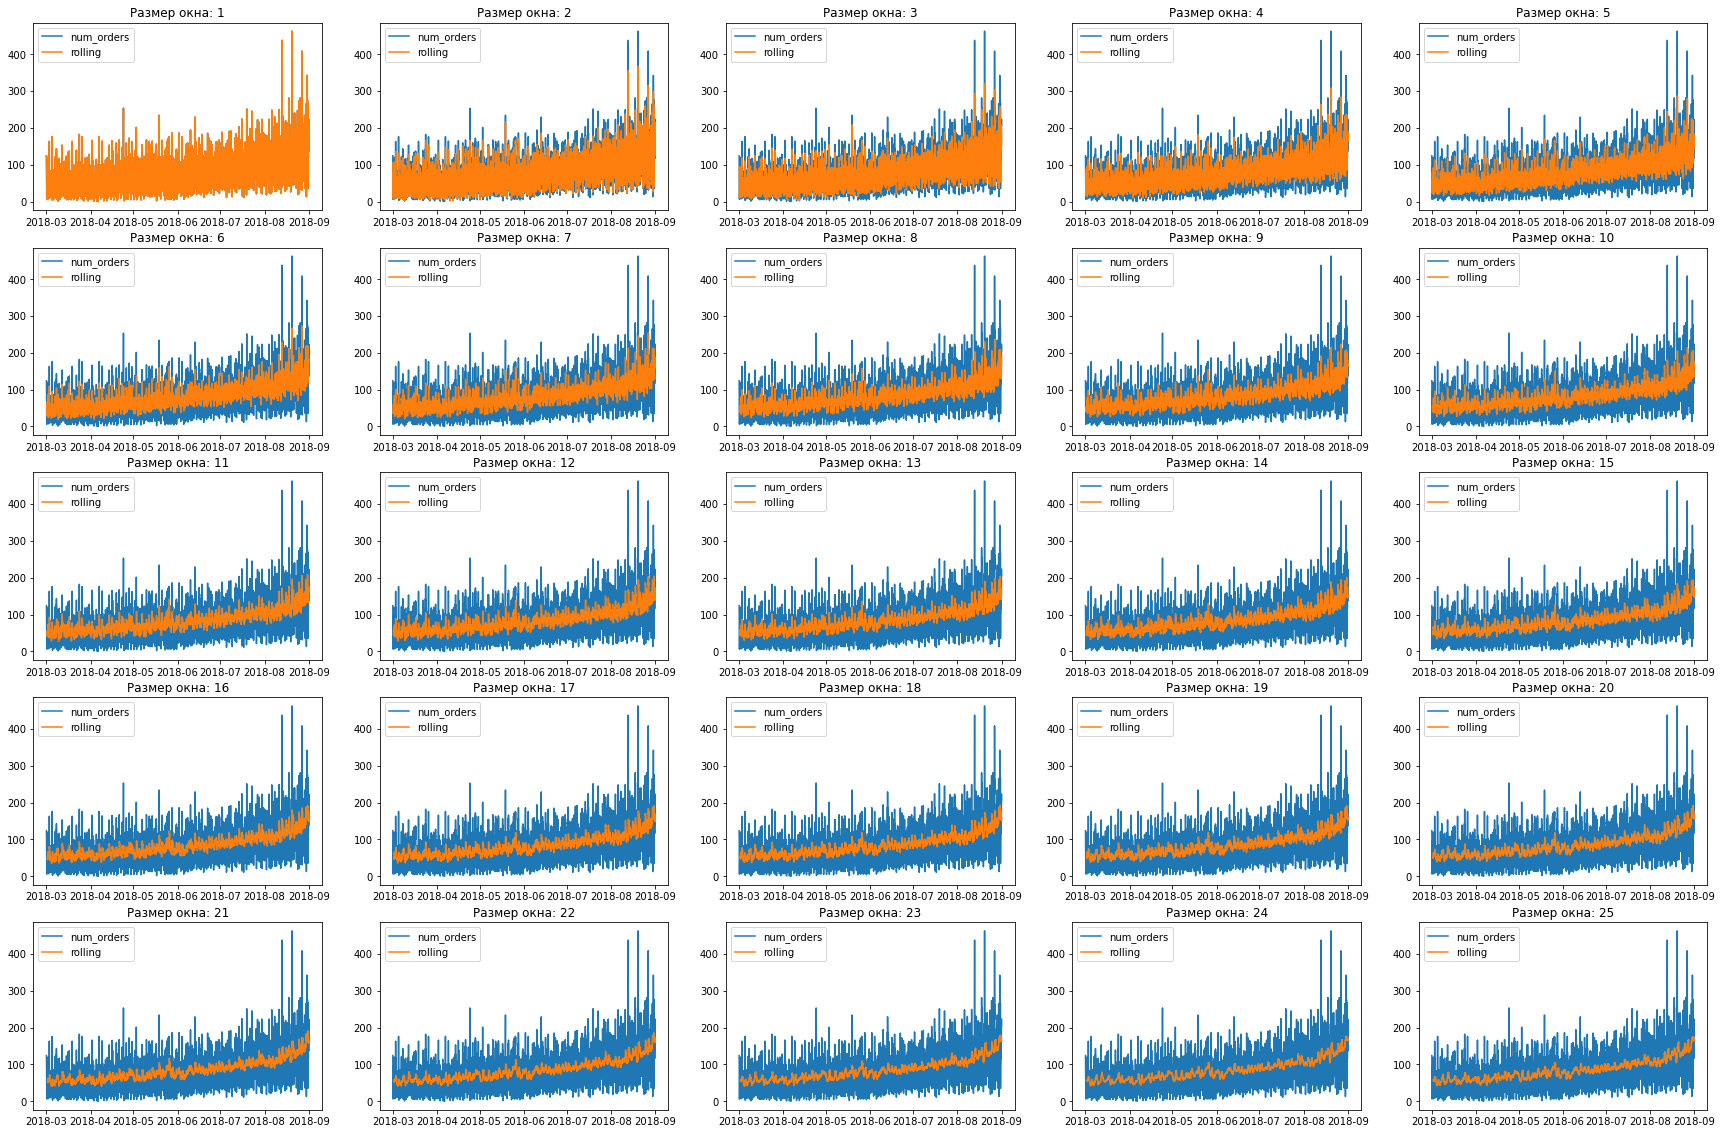

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(30, 20))
windows_size = 1
for i in range(5):
    for j in range(5):
        df['rolling'] = df.rolling(windows_size).mean()
        axes[i, j].plot(df['num_orders'], label='num_orders')
        axes[i, j].plot(df['rolling'], label='rolling')
        axes[i, j].legend()
        axes[i, j].set_title('Размер окна: {}'.format(windows_size))
        windows_size += 1

Последовательно в цикле перебирался размер окна от 1 до 25. На полученных графиках синяя лииня - исходный временной ряд, жёлтая - сглаженный временной ряд. 

Закономерно видим, что по мере увеличения размера окна колебания сглаженного ряда всё менее и менее заметны.

Проанализируем компоненты временного ряда.

Разложим его на тренд, сезон и ошибку. При анализе сезонной компоненты рассмотрим её динамику за 3 дня.

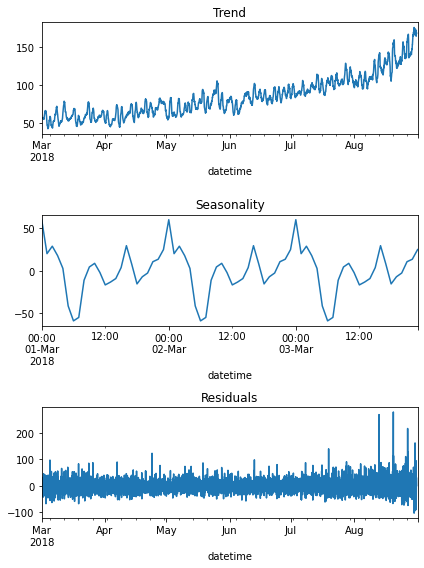

In [8]:
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим, что тенденция указывает на поступательный рост числа заказов в такси.

Сезонная компонента имеет суточный характер. Проанализируем сезонность за суточный интервал, чтобы было легче интерпретировать график.

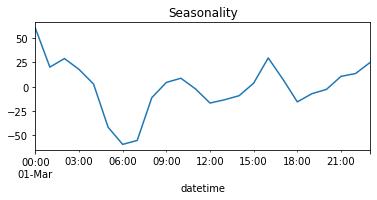

In [9]:
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(6, 8))
plt.subplot(312)
decomposed.seasonal['2018-03-01'].plot(ax=plt.gca())
plt.title('Seasonality');

Видим, что основные пики заказов приходятся на промежуток с 6 утра до 10-11 утра. Это кажется логичным, так как в это время люди спешат на работу, и многие из них часто пользуются услугами такси, если, например, хочется поспать подольше, или же человек просто проспал. 

Второй пик активности заказов - промежуток с 6 вечера до 1-2 ночи: в это время люди, вероятно, посещают какие-то заведения и пользуются услугами такси, чтобы добраться домой после кутежа.

С другой стороны, миннимальное число заказов наблюдается в промежутке с 1-2 часов ночи до 6 утра. Оно и неудивительно - люди ещё спят в большинстве своём.

Очевидно, что ряд не является стационарным: среднее значение количества заказов со временем увеличивается.

Чтобы прийти к более-менее стационарному ряду, подходящему для прогноза, используем метод сдвига.

In [10]:
df['shift'] = df['num_orders'] - df['num_orders'].shift(fill_value=0)

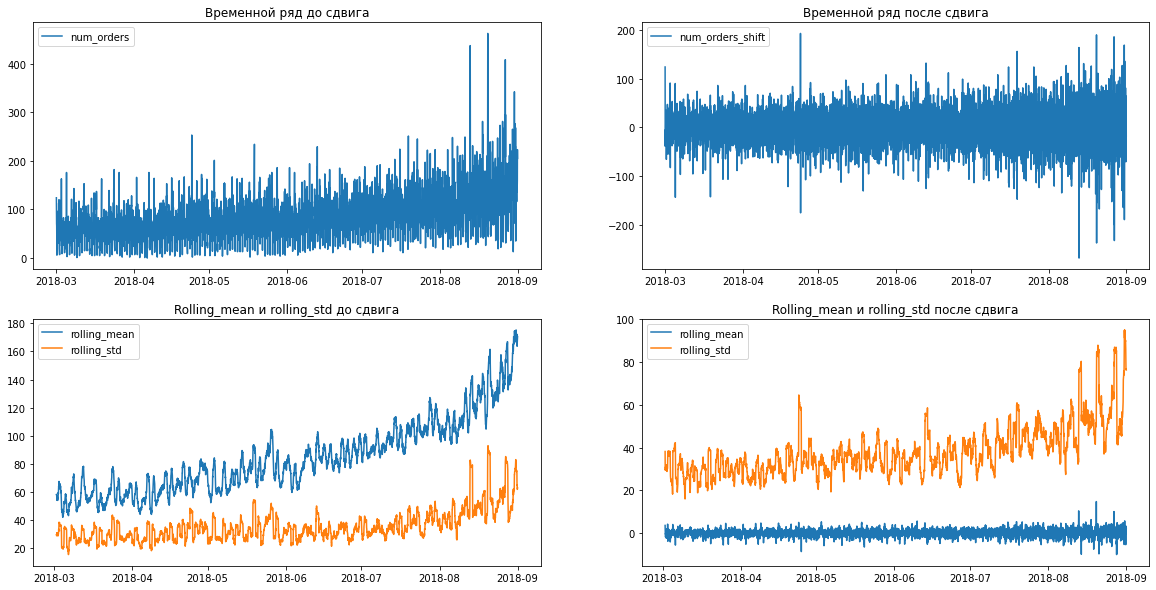

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 10))

axes[0, 0].plot(df['num_orders'], label = 'num_orders')
axes[0, 0].set_title('Временной ряд до сдвига')
axes[0, 0].legend()

axes[0, 1].plot(df['shift'], label = 'num_orders_shift')
axes[0, 1].set_title('Временной ряд после сдвига')
axes[0, 1].legend()

axes[1, 0].plot(df['num_orders'].rolling(25).mean(), label = 'rolling_mean')
axes[1, 0].plot(df['num_orders'].rolling(25).std(), label = 'rolling_std')
axes[1, 0].set_title('Rolling_mean и rolling_std до сдвига')
axes[1, 0].legend()


axes[1, 1].plot(df['shift'].rolling(25).mean(), label = 'rolling_mean')
axes[1, 1].plot(df['shift'].rolling(25).std(), label = 'rolling_std')
axes[1, 1].set_title('Rolling_mean и rolling_std после сдвига')
axes[1, 1].legend();

In [12]:
df.drop(['shift', 'rolling'], axis=1, inplace=True)

<a id='2.2'></a> 
## Этап 2.2. Подготовка новых признаков.

Напишем функцию для генерирования новых признаков. Функция будет принимать на вход набор данных, максимальную величину сдвига, а также величину окна для сглаживания временного ряда.

На выход функция будет предоставлять набор данных, обогащённый новыми признаками: год, месяц, день и день недели на дату измерения количества заказов, значения количества заказов при сдвиге на величину лага, а также скользящее среднее и скользящее стандартное отклонение временного ряда.

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df['rolling_std'] = df['num_orders'].shift().rolling(rolling_mean_size).std()

Функция написана. Применим функцию к нашему набору данных.

В качестве временного сдвига и окна для сглаживания используем значение 24, так как мы имеем временной ряд с частотой обновления данных в 1 час.

In [14]:
make_features(df, 24, 15)

Проверим, что получилось.

In [15]:
df.head(5)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Новые признаки созданы, в ходе их создания появились пропущенные значения. Удалим их.

In [16]:
df = df.dropna()

# Вывод по этапу 2.

На данном этапе мы проанализировали временной ряд и создали новые признаки.

Была осуществлена проверка упорядоченности индексов (дат) по возрастанию, визуализирован временной ряд, применена техника скользящего среднего с размером окна от 1 до 25 для сглаживания временного ряда, разложение временного ряда на компоненты (тренд, сезон, ошибка), а также сгенерированы новые признаки: год, месяц, день и день недели на дату измерения количества заказов, значения количества заказов при сдвиге на величину лага, а также скользящее среднее и скользящее стандартное отклонение временного ряда. 

В ходе анализа удалось отметить, что временной ряд демонстрирует явную тенденцию к увеличению количества заказов, имея при этом суточную сезонность: пиковое время, когда заказов больше всего - промежуток с 6 утра до 10-11 утра и с 6 вечера до 1-2 ночи. Напротив, наименее продуктивным временем считается промежуток с 2 часов ночи до 6 часов утра.

# Этап 3. Обучение и тестирование моделей, подбор гиперпараметров.

В рамках данного этапа проттестируем модели LinearRegression, CatBoost, LightGBM и RandomForest.

Сначала выделим признаки и таргет.

In [17]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

Разделим признаки и таргет на тренировочную и тестовую выборки. Так как мы имеем дело с временными рядами, данные при разделении нельзя перемешивать, иначе модель заглянет в будущее. Поэтому передаём параметру shuffle значение False.

Размер тестовой выборки оставим в 10% от общего набора данных.

In [18]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.10, 
                                                                            random_state = 42, shuffle = False)

Посмотрим, правильно ли получилось. Выведем на экран минимальную и максимальную дату в тренировочном и тестовом наборе данных.

In [19]:
print('Минимальная дата в тренировочной выборке: {}'.format(features_train.index.min()))
print('Максимальная дата в тренировочной выборке: {}'.format(features_train.index.max()))
print('Минимальная дата в тестовой выборке: {}'.format(features_test.index.min()))
print('Максимальная дата в тестовой выборке: {}'.format(features_test.index.max()))

Минимальная дата в тренировочной выборке: 2018-03-02 00:00:00
Максимальная дата в тренировочной выборке: 2018-08-13 15:00:00
Минимальная дата в тестовой выборке: 2018-08-13 16:00:00
Максимальная дата в тестовой выборке: 2018-08-31 23:00:00


<a id='3.1'></a> 
## Этап 3.1. LinearRegression.

Протестируем модель линейной регрессии.

Модель линейной регрессии является простой, поэтому для неё не нужно подбирать гиперпараметры.

In [20]:
model = LinearRegression(normalize=True)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('RMSE на отложенной выборке для линейной регрессии:', round(mse(target_test, predictions, squared=False), 6))

RMSE на отложенной выборке для линейной регрессии: 45.471279


Видим, что на тестовой выборке модель линейной регрессии обеспечивает RMSE на уровне 45.47 заказов, что является довольно хорошим результатом и соответствует требованию проекта в части значения RMSE не более 48.

Однако ради интереса протестируем другие модели другие модели.

<a id='3.2'></a> 
## Этап 3.2. CatBoost.

CatBoost прекрасно тюнит сам себя во время обучения, поэтому не будем ему мешать, а то сделает кусь.

In [21]:
model = CatBoostRegressor(loss_function='RMSE', iterations=1000, random_state=40)
model.fit(features_train, target_train, plot = True, verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.049846
0:	learn: 37.8076189	total: 57.1ms	remaining: 57s
50:	learn: 24.3509893	total: 221ms	remaining: 4.11s
100:	learn: 22.5342126	total: 373ms	remaining: 3.32s
150:	learn: 21.5564060	total: 523ms	remaining: 2.94s
200:	learn: 20.2831774	total: 691ms	remaining: 2.75s
250:	learn: 19.3024103	total: 849ms	remaining: 2.53s
300:	learn: 18.3673808	total: 1.02s	remaining: 2.37s
350:	learn: 17.4969695	total: 1.19s	remaining: 2.2s
400:	learn: 16.7542536	total: 1.34s	remaining: 2.01s
450:	learn: 16.1041968	total: 1.51s	remaining: 1.84s
500:	learn: 15.4672643	total: 1.69s	remaining: 1.68s
550:	learn: 14.8938162	total: 1.84s	remaining: 1.5s
600:	learn: 14.3313608	total: 2.01s	remaining: 1.33s
650:	learn: 13.8135738	total: 2.17s	remaining: 1.16s
700:	learn: 13.4219394	total: 2.31s	remaining: 987ms
750:	learn: 12.9633561	total: 2.47s	remaining: 818ms
800:	learn: 12.5656172	total: 2.61s	remaining: 648ms
850:	learn: 12.1243247	total: 2.76s	remaining: 484ms
900:	learn: 11.7513537

In [22]:
predictions = model.predict(features_test)
print('RMSE на отложенной выборке для CatBoost:', round(mse(target_test, predictions, squared=False), 6))

RMSE на отложенной выборке для CatBoost: 39.348182


CatBoost отработал лучше, чем линейная регрессия: CatBoost предсказывает количество заказов c ошибкой в 39.35 заказов (точнее на 6.12 заказов по сравнению с LinearRegresion). При этом по скорости обучения модели идут практически на одном уровне.

CatBoost также обеспечивает требуемый заказчиком уровнеь точности. Тем не менее, протестируем другие модели.

<a id='3.3'></a> 
## Этап 3.3. LightGBM.


Протестируем LightGBM.

Для подбора гиперпараметров будем использовать GridSearchSV. Так как метрика RMSE оптимизируется в сторону минимума, напишем свою метрику оценки, которая будет указывать, что чем меньше значением, тем лучше. Для этого передаём аргумет False параметру greater_is_better.

Также GridSearchSV использует вшитый алгоритм кросс-валидации, основанной на перемешивании объектов. Так как мы работаем с временным рядом, перемешивать объекты нельзя. 
Чтобы кросс-валидация работала корректно, напишем свою кросс-валидацию.

Используем модуль TimeSeriesSplit, который подходит для реализации концепции кросс-валидации для временных рядов.

Оптимизировать будем 2 параметра: learning_rate (скорость обучения) и num_leaves (количество листьев на дереве).

In [23]:
scorer = make_scorer(mse, greater_is_better=False, squared=False)
cross_val = TimeSeriesSplit(n_splits=5)

model = LGBMRegressor(n_estimators=1000, colsample_bytree=0.6, subsample=0.6, random_state=41)

grid_params = {
    'learning_rate' : [round(i,3) for i in np.arange(0.01, 0.21, 0.010)],
    'num_leaves' : [i for i in range(1, 102, 5)]
}

gs = GridSearchCV(model, grid_params, scoring=scorer, cv=cross_val, verbose=10)
with parallel_backend('threading'):
    gs.fit(features_train, target_train, eval_metric = 'RMSE')
print('Лучшее значение RMSE:', -1 * round(gs.best_score_, 6))
print('Оптимальные значения гиперпараметров:', gs.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
[CV] learning_rate=0.01, num_leaves=1 ................................[CV] learning_rate=0.01, num_leaves=1 ................................[CV] learning_rate=0.01, num_leaves=1 ................................[CV] learning_rate=0.01, num_leaves=1 ................................


[CV] learning_rate=0.01, num_leaves=1 ................................[CV] learning_rate=0.01, num_leaves=6 ................................


[CV] learning_rate=0.01, num_leaves=6 ................................[CV] learning_rate=0.01, num_leaves=6 ................................
[CV] learning_rate=0.01, num_leaves=6 ................................
[CV] learning_rate=0.01, num_leaves=6 ................................
[CV] learning_rate=0.01, num_leaves=11 ...............................
[CV] learning_rate=0.01, num_leaves=11 ...............................
[CV] learning_rate=0.01, num_leaves=11 ...............................[CV] learning_r

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[CV] ...... learning_rate=0.01, num_leaves=1, score=nan, total=   0.1s[CV] ...... learning_rate=0.01, num_leaves=1, score=nan, total=   0.1s[CV] ...... learning_rate=0.01, num_leaves=1, score=nan, total=   0.1s
[CV] learning_rate=0.01, num_leaves=16 ...............................
[CV] ...... learning_rate=0.01, num_leaves=1, score=nan, total=   0.1s
[CV] learning_rate=0.01, num_leaves=16 ...............................


[CV] learning_rate=0.01, num_leaves=16 ...............................
[CV] learning_rate=0.01, num_leaves=16 ...............................
[CV] ...... learning_rate=0.01, num_leaves=1, score=nan, total=   0.1s
[CV] learning_rate=0.01, num_leaves=21 ...............................
[CV] .. learning_rate=0.01, num_leaves=6, score=-22.238, total=   1.5s
[CV] learning_rate=0.01, num_leaves=21 ...............................
[CV] .. learning_rate=0.01, num_leaves=6, score=-21.937, total=   1.6s
[CV] learning_rate=0.01, num_leaves=21 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s


[CV] . learning_rate=0.01, num_leaves=11, score=-21.901, total=   2.8s
[CV] learning_rate=0.01, num_leaves=26 ...............................
[CV] . learning_rate=0.01, num_leaves=11, score=-23.635, total=   2.8s
[CV] learning_rate=0.01, num_leaves=26 ...............................
[CV] . learning_rate=0.01, num_leaves=11, score=-26.097, total=   2.9s
[CV] learning_rate=0.01, num_leaves=26 ...............................
[CV] . learning_rate=0.01, num_leaves=11, score=-33.218, total=   3.0s
[CV] learning_rate=0.01, num_leaves=26 ...............................
[CV] . learning_rate=0.01, num_leaves=11, score=-22.262, total=   3.3s
[CV] learning_rate=0.01, num_leaves=31 ...............................
[CV] . learning_rate=0.01, num_leaves=16, score=-22.469, total=   3.8s
[CV] learning_rate=0.01, num_leaves=31 ...............................
[CV] . learning_rate=0.01, num_leaves=16, score=-22.098, total=   3.9s
[CV] learning_rate=0.01, num_leaves=31 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s



[CV] learning_rate=0.01, num_leaves=31 ...............................
[CV] . learning_rate=0.01, num_leaves=16, score=-32.712, total=   4.2s
[CV] learning_rate=0.01, num_leaves=36 ...............................
[CV] . learning_rate=0.01, num_leaves=21, score=-22.611, total=   5.5s
[CV] learning_rate=0.01, num_leaves=36 ...............................
[CV] . learning_rate=0.01, num_leaves=21, score=-22.341, total=   4.9s
[CV] learning_rate=0.01, num_leaves=36 ...............................
[CV] . learning_rate=0.01, num_leaves=21, score=-23.636, total=   5.0s
[CV] learning_rate=0.01, num_leaves=36 ...............................
[CV] . learning_rate=0.01, num_leaves=21, score=-25.804, total=   5.0s
[CV] learning_rate=0.01, num_leaves=36 ...............................
[CV] . learning_rate=0.01, num_leaves=21, score=-32.648, total=   5.1s
[CV] learning_rate=0.01, num_leaves=41 ...............................
[CV] . learning_rate=0.01, num_leaves=26, score=-22.525, total=   5.5s
[CV] 

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.2s



[CV] learning_rate=0.01, num_leaves=46 ...............................
[CV] . learning_rate=0.01, num_leaves=26, score=-32.633, total=   6.7s
[CV] learning_rate=0.01, num_leaves=46 ...............................
[CV] . learning_rate=0.01, num_leaves=36, score=-22.586, total=   5.6s
[CV] learning_rate=0.01, num_leaves=46 ...............................
[CV] . learning_rate=0.01, num_leaves=31, score=-22.326, total=   7.1s
[CV] learning_rate=0.01, num_leaves=46 ...............................
[CV] . learning_rate=0.01, num_leaves=31, score=-23.716, total=   7.2s
[CV] learning_rate=0.01, num_leaves=46 ...............................
[CV] . learning_rate=0.01, num_leaves=31, score=-25.746, total=   7.2s
[CV] learning_rate=0.01, num_leaves=51 ...............................
[CV] . learning_rate=0.01, num_leaves=31, score=-32.731, total=   7.4s
[CV] learning_rate=0.01, num_leaves=51 ...............................
[CV] . learning_rate=0.01, num_leaves=41, score=-22.586, total=   5.6s
[CV] 

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.6s


[CV] . learning_rate=0.01, num_leaves=46, score=-22.586, total=   5.9s
[CV] learning_rate=0.01, num_leaves=56 ...............................
[CV] . learning_rate=0.01, num_leaves=41, score=-22.254, total=   8.6s
[CV] learning_rate=0.01, num_leaves=56 ...............................
[CV] . learning_rate=0.01, num_leaves=51, score=-22.586, total=   4.8s
[CV] learning_rate=0.01, num_leaves=56 ...............................
[CV] . learning_rate=0.01, num_leaves=41, score=-23.745, total=   8.4s
[CV] learning_rate=0.01, num_leaves=61 ...............................
[CV] . learning_rate=0.01, num_leaves=41, score=-25.620, total=   8.5s
[CV] learning_rate=0.01, num_leaves=61 ...............................
[CV] . learning_rate=0.01, num_leaves=41, score=-32.882, total=   8.6s
[CV] learning_rate=0.01, num_leaves=61 ...............................
[CV] . learning_rate=0.01, num_leaves=46, score=-22.201, total=   9.2s
[CV] learning_rate=0.01, num_leaves=61 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   21.1s


[CV] . learning_rate=0.01, num_leaves=61, score=-22.586, total=   4.9s
[CV] learning_rate=0.01, num_leaves=66 ...............................
[CV] . learning_rate=0.01, num_leaves=51, score=-23.844, total=  10.0s
[CV] learning_rate=0.01, num_leaves=71 ...............................
[CV] . learning_rate=0.01, num_leaves=51, score=-25.679, total=  10.0s
[CV] learning_rate=0.01, num_leaves=71 ...............................
[CV] . learning_rate=0.01, num_leaves=56, score=-22.279, total=   9.3s
[CV] learning_rate=0.01, num_leaves=71 ...............................
[CV] . learning_rate=0.01, num_leaves=66, score=-22.586, total=   4.7s
[CV] learning_rate=0.01, num_leaves=71 ...............................
[CV] . learning_rate=0.01, num_leaves=51, score=-32.765, total=  10.3s
[CV] learning_rate=0.01, num_leaves=71 ...............................
[CV] . learning_rate=0.01, num_leaves=56, score=-23.874, total=  10.7s
[CV] learning_rate=0.01, num_leaves=76 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   29.4s


[CV] . learning_rate=0.01, num_leaves=76, score=-22.586, total=   4.7s
[CV] learning_rate=0.01, num_leaves=81 ...............................
[CV] . learning_rate=0.01, num_leaves=61, score=-25.669, total=  12.0s
[CV] learning_rate=0.01, num_leaves=81 ...............................
[CV] . learning_rate=0.01, num_leaves=61, score=-32.824, total=  11.8s
[CV] learning_rate=0.01, num_leaves=81 ...............................
[CV] . learning_rate=0.01, num_leaves=66, score=-23.908, total=  12.0s
[CV] learning_rate=0.01, num_leaves=86 ...............................
[CV] . learning_rate=0.01, num_leaves=71, score=-22.279, total=   9.2s
[CV] learning_rate=0.01, num_leaves=86 ...............................
[CV] . learning_rate=0.01, num_leaves=66, score=-25.802, total=  12.5s
[CV] learning_rate=0.01, num_leaves=86 ...............................
[CV] . learning_rate=0.01, num_leaves=81, score=-22.586, total=   4.8s
[CV] learning_rate=0.01, num_leaves=86 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   40.5s


[CV] . learning_rate=0.01, num_leaves=76, score=-25.722, total=  14.2s
[CV] learning_rate=0.01, num_leaves=96 ...............................
[CV] . learning_rate=0.01, num_leaves=76, score=-32.625, total=  14.4s
[CV] learning_rate=0.01, num_leaves=96 ...............................
[CV] . learning_rate=0.01, num_leaves=86, score=-22.279, total=   9.3s
[CV] learning_rate=0.01, num_leaves=101 ..............................
[CV] . learning_rate=0.01, num_leaves=96, score=-22.586, total=   4.7s
[CV] learning_rate=0.01, num_leaves=101 ..............................
[CV] . learning_rate=0.01, num_leaves=81, score=-23.989, total=  13.7s
[CV] learning_rate=0.01, num_leaves=101 ..............................
[CV] . learning_rate=0.01, num_leaves=91, score=-22.279, total=   9.4s
[CV] learning_rate=0.01, num_leaves=101 ..............................
[CV] . learning_rate=0.01, num_leaves=81, score=-32.583, total=  15.3s
[CV] learning_rate=0.01, num_leaves=101 ..............................
[CV] .

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   47.2s


[CV] . learning_rate=0.01, num_leaves=86, score=-23.987, total=  14.0s
[CV] learning_rate=0.02, num_leaves=6 ................................
[CV] .. learning_rate=0.02, num_leaves=6, score=-22.494, total=   1.4s
[CV] learning_rate=0.02, num_leaves=6 ................................
[CV] .. learning_rate=0.02, num_leaves=6, score=-21.841, total=   1.4s
[CV] learning_rate=0.02, num_leaves=6 ................................
[CV] .. learning_rate=0.02, num_leaves=6, score=-23.545, total=   1.3s
[CV] learning_rate=0.02, num_leaves=11 ...............................
[CV] .. learning_rate=0.02, num_leaves=6, score=-26.271, total=   1.4s
[CV] learning_rate=0.02, num_leaves=11 ...............................
[CV] . learning_rate=0.01, num_leaves=86, score=-25.804, total=  16.0s
[CV] learning_rate=0.02, num_leaves=11 ...............................
[CV] .. learning_rate=0.02, num_leaves=6, score=-33.338, total=   1.5s
[CV] learning_rate=0.02, num_leaves=11 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   54.7s


[CV] . learning_rate=0.01, num_leaves=91, score=-25.828, total=  17.5s
[CV] learning_rate=0.02, num_leaves=21 ...............................
[CV] . learning_rate=0.01, num_leaves=96, score=-23.987, total=  14.7s
[CV] learning_rate=0.02, num_leaves=26 ...............................
[CV] . learning_rate=0.02, num_leaves=16, score=-22.504, total=   3.7s
[CV] learning_rate=0.02, num_leaves=26 ...............................
[CV] . learning_rate=0.02, num_leaves=16, score=-23.614, total=   3.7s
[CV] learning_rate=0.02, num_leaves=26 ...............................
[CV] . learning_rate=0.01, num_leaves=91, score=-32.569, total=  18.1s
[CV] learning_rate=0.02, num_leaves=26 ...............................
[CV] . learning_rate=0.02, num_leaves=16, score=-25.901, total=   4.1s
[CV] learning_rate=0.02, num_leaves=26 ...............................
[CV] . learning_rate=0.02, num_leaves=16, score=-32.459, total=   3.9s
[CV] learning_rate=0.02, num_leaves=31 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.0min


[CV] . learning_rate=0.01, num_leaves=96, score=-32.732, total=  19.9s
[CV] learning_rate=0.02, num_leaves=41 ...............................
[CV] . learning_rate=0.02, num_leaves=31, score=-22.678, total=   5.6s
[CV] learning_rate=0.02, num_leaves=41 ...............................
[CV] . learning_rate=0.02, num_leaves=26, score=-25.677, total=   6.1s
[CV] learning_rate=0.02, num_leaves=41 ...............................
[CV] . learning_rate=0.02, num_leaves=26, score=-32.715, total=   6.3s
[CV] learning_rate=0.02, num_leaves=41 ...............................
[CV] . learning_rate=0.02, num_leaves=31, score=-22.542, total=   6.7s
[CV] learning_rate=0.02, num_leaves=46 ...............................
[CV] . learning_rate=0.02, num_leaves=31, score=-23.715, total=   6.9s
[CV] learning_rate=0.02, num_leaves=46 ...............................
[CV] . learning_rate=0.02, num_leaves=31, score=-25.730, total=   6.9s
[CV] learning_rate=0.02, num_leaves=46 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.2min


[CV] . learning_rate=0.02, num_leaves=41, score=-25.752, total=   8.5s
[CV] learning_rate=0.02, num_leaves=61 ...............................
[CV] . learning_rate=0.02, num_leaves=51, score=-22.678, total=   5.2s
[CV] learning_rate=0.02, num_leaves=61 ...............................
[CV] . learning_rate=0.02, num_leaves=41, score=-32.939, total=   8.9s
[CV] learning_rate=0.02, num_leaves=61 ...............................
[CV] . learning_rate=0.02, num_leaves=56, score=-22.678, total=   4.9s
[CV] learning_rate=0.02, num_leaves=61 ...............................
[CV] . learning_rate=0.02, num_leaves=46, score=-22.572, total=   9.1s
[CV] learning_rate=0.02, num_leaves=61 ...............................
[CV] . learning_rate=0.02, num_leaves=46, score=-23.887, total=   9.3s
[CV] learning_rate=0.02, num_leaves=66 ...............................
[CV] . learning_rate=0.02, num_leaves=46, score=-25.821, total=   9.3s
[CV] learning_rate=0.02, num_leaves=66 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min


[CV] . learning_rate=0.02, num_leaves=71, score=-22.678, total=   4.9s
[CV] learning_rate=0.02, num_leaves=76 ...............................
[CV] . learning_rate=0.02, num_leaves=61, score=-23.983, total=  11.9s
[CV] learning_rate=0.02, num_leaves=81 ...............................
[CV] . learning_rate=0.02, num_leaves=66, score=-22.432, total=   9.4s
[CV] learning_rate=0.02, num_leaves=81 ...............................
[CV] . learning_rate=0.02, num_leaves=76, score=-22.678, total=   4.8s
[CV] learning_rate=0.02, num_leaves=81 ...............................
[CV] . learning_rate=0.02, num_leaves=61, score=-25.760, total=  12.0s
[CV] learning_rate=0.02, num_leaves=81 ...............................
[CV] . learning_rate=0.02, num_leaves=61, score=-32.922, total=  11.9s
[CV] learning_rate=0.02, num_leaves=81 ...............................
[CV] . learning_rate=0.02, num_leaves=71, score=-22.432, total=   9.7s
[CV] learning_rate=0.02, num_leaves=86 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.6min


[CV] . learning_rate=0.02, num_leaves=86, score=-22.432, total=  10.5s
[CV] learning_rate=0.02, num_leaves=101 ..............................
[CV] . learning_rate=0.02, num_leaves=96, score=-22.678, total=   5.6s
[CV] learning_rate=0.02, num_leaves=101 ..............................
[CV] . learning_rate=0.02, num_leaves=81, score=-23.856, total=  15.6s
[CV] learning_rate=0.02, num_leaves=101 ..............................
[CV] . learning_rate=0.02, num_leaves=91, score=-22.432, total=  10.5s
[CV] learning_rate=0.02, num_leaves=101 ..............................
[CV] . learning_rate=0.02, num_leaves=81, score=-32.589, total=  17.0s
[CV] learning_rate=0.02, num_leaves=101 ..............................
[CV] . learning_rate=0.02, num_leaves=81, score=-25.847, total=  17.3s
[CV] learning_rate=0.03, num_leaves=1 ................................
[CV] ...... learning_rate=0.03, num_leaves=1, score=nan, total=   0.0s
[CV] learning_rate=0.03, num_leaves=1 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.8min


[CV] . learning_rate=0.02, num_leaves=91, score=-23.864, total=  16.3s
[CV] learning_rate=0.03, num_leaves=16 ...............................
[CV] . learning_rate=0.03, num_leaves=11, score=-22.684, total=   2.9s
[CV] learning_rate=0.03, num_leaves=16 ...............................
[CV] . learning_rate=0.03, num_leaves=11, score=-22.362, total=   3.0s
[CV] learning_rate=0.03, num_leaves=16 ...............................
[CV] . learning_rate=0.03, num_leaves=11, score=-23.624, total=   2.9s
[CV] learning_rate=0.03, num_leaves=16 ...............................
[CV] . learning_rate=0.03, num_leaves=11, score=-26.060, total=   2.8s
[CV] learning_rate=0.03, num_leaves=21 ...............................
[CV] . learning_rate=0.03, num_leaves=11, score=-33.202, total=   2.9s
[CV] learning_rate=0.03, num_leaves=21 ...............................
[CV]  learning_rate=0.02, num_leaves=101, score=-22.432, total=  11.1s
[CV] learning_rate=0.03, num_leaves=21 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  2.0min


[CV] . learning_rate=0.03, num_leaves=26, score=-22.681, total=   5.8s
[CV] learning_rate=0.03, num_leaves=36 ...............................
[CV] . learning_rate=0.03, num_leaves=26, score=-24.053, total=   5.8s
[CV] learning_rate=0.03, num_leaves=41 ...............................
[CV] . learning_rate=0.03, num_leaves=26, score=-25.769, total=   5.8s
[CV] learning_rate=0.03, num_leaves=41 ...............................
[CV] . learning_rate=0.03, num_leaves=31, score=-22.613, total=   5.4s
[CV] learning_rate=0.03, num_leaves=41 ...............................
[CV] . learning_rate=0.02, num_leaves=96, score=-32.557, total=  21.1s
[CV] learning_rate=0.03, num_leaves=41 ...............................
[CV] . learning_rate=0.03, num_leaves=26, score=-32.849, total=   6.1s
[CV] learning_rate=0.03, num_leaves=41 ...............................
[CV] . learning_rate=0.03, num_leaves=31, score=-22.665, total=   6.8s
[CV] learning_rate=0.03, num_leaves=46 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  2.1min


[CV] . learning_rate=0.03, num_leaves=51, score=-22.613, total=   5.2s
[CV] learning_rate=0.03, num_leaves=61 ...............................
[CV] . learning_rate=0.03, num_leaves=56, score=-22.613, total=   5.1s
[CV] learning_rate=0.03, num_leaves=61 ...............................
[CV] . learning_rate=0.03, num_leaves=46, score=-22.584, total=   9.3s
[CV] learning_rate=0.03, num_leaves=61 ...............................
[CV] . learning_rate=0.03, num_leaves=46, score=-23.993, total=   9.5s
[CV] learning_rate=0.03, num_leaves=66 ...............................
[CV] . learning_rate=0.03, num_leaves=46, score=-25.836, total=   9.6s
[CV] learning_rate=0.03, num_leaves=66 ...............................
[CV] . learning_rate=0.03, num_leaves=46, score=-33.105, total=   9.6s
[CV] learning_rate=0.03, num_leaves=66 ...............................
[CV] . learning_rate=0.03, num_leaves=61, score=-22.613, total=   5.5s
[CV] learning_rate=0.03, num_leaves=66 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  2.4min


[CV] . learning_rate=0.03, num_leaves=66, score=-25.761, total=  13.0s
[CV] learning_rate=0.03, num_leaves=86 ...............................
[CV] . learning_rate=0.03, num_leaves=81, score=-22.613, total=   5.1s
[CV] learning_rate=0.03, num_leaves=86 ...............................
[CV] . learning_rate=0.03, num_leaves=66, score=-32.870, total=  13.1s
[CV] learning_rate=0.03, num_leaves=86 ...............................
[CV] . learning_rate=0.03, num_leaves=76, score=-22.643, total=   9.5s
[CV] learning_rate=0.03, num_leaves=91 ...............................
[CV] . learning_rate=0.03, num_leaves=86, score=-22.613, total=   4.8s
[CV] learning_rate=0.03, num_leaves=91 ...............................
[CV] . learning_rate=0.03, num_leaves=71, score=-25.860, total=  13.4s
[CV] learning_rate=0.03, num_leaves=91 ...............................
[CV] . learning_rate=0.03, num_leaves=71, score=-24.047, total=  13.8s
[CV] learning_rate=0.03, num_leaves=91 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  2.7min


[CV] . learning_rate=0.03, num_leaves=86, score=-23.981, total=  14.0s
[CV] learning_rate=0.04, num_leaves=6 ................................
[CV] .. learning_rate=0.04, num_leaves=6, score=-22.591, total=   1.3s
[CV] learning_rate=0.04, num_leaves=6 ................................
[CV] .. learning_rate=0.04, num_leaves=6, score=-22.076, total=   1.4s
[CV] learning_rate=0.04, num_leaves=6 ................................
[CV] .. learning_rate=0.04, num_leaves=6, score=-23.736, total=   1.3s
[CV] learning_rate=0.04, num_leaves=11 ...............................
[CV] .. learning_rate=0.04, num_leaves=6, score=-26.059, total=   1.4s
[CV] learning_rate=0.04, num_leaves=11 ...............................
[CV] . learning_rate=0.03, num_leaves=86, score=-25.839, total=  16.1s
[CV] learning_rate=0.04, num_leaves=11 ...............................
[CV] . learning_rate=0.03, num_leaves=96, score=-22.643, total=   9.7s
[CV] learning_rate=0.04, num_leaves=11 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  2.9min


[CV]  learning_rate=0.03, num_leaves=101, score=-23.981, total=  15.3s
[CV] learning_rate=0.04, num_leaves=31 ...............................
[CV] . learning_rate=0.04, num_leaves=21, score=-25.817, total=   4.9s
[CV] learning_rate=0.04, num_leaves=36 ...............................
[CV] . learning_rate=0.04, num_leaves=21, score=-32.817, total=   4.9s
[CV] learning_rate=0.04, num_leaves=36 ...............................
[CV] . learning_rate=0.03, num_leaves=96, score=-25.834, total=  19.2s
[CV] learning_rate=0.04, num_leaves=36 ...............................
[CV] . learning_rate=0.04, num_leaves=26, score=-22.850, total=   5.6s
[CV] learning_rate=0.04, num_leaves=36 ...............................
[CV] . learning_rate=0.03, num_leaves=96, score=-32.431, total=  19.4s
[CV] learning_rate=0.04, num_leaves=36 ...............................
[CV] . learning_rate=0.04, num_leaves=26, score=-22.832, total=   5.9s
[CV] learning_rate=0.04, num_leaves=41 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:  3.0min


[CV] . learning_rate=0.04, num_leaves=41, score=-32.796, total=   8.3s
[CV] learning_rate=0.04, num_leaves=61 ...............................
[CV] . learning_rate=0.04, num_leaves=51, score=-22.808, total=   5.0s
[CV] learning_rate=0.04, num_leaves=61 ...............................
[CV] . learning_rate=0.04, num_leaves=56, score=-22.808, total=   4.6s
[CV] learning_rate=0.04, num_leaves=61 ...............................
[CV] . learning_rate=0.04, num_leaves=46, score=-22.534, total=   8.7s
[CV] learning_rate=0.04, num_leaves=61 ...............................
[CV] . learning_rate=0.04, num_leaves=46, score=-24.040, total=   8.8s
[CV] learning_rate=0.04, num_leaves=66 ...............................
[CV] . learning_rate=0.04, num_leaves=46, score=-26.131, total=   8.9s
[CV] learning_rate=0.04, num_leaves=66 ...............................
[CV] . learning_rate=0.04, num_leaves=46, score=-33.093, total=   8.8s
[CV] learning_rate=0.04, num_leaves=66 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  3.3min


[CV] . learning_rate=0.04, num_leaves=76, score=-22.666, total=   9.5s
[CV] learning_rate=0.04, num_leaves=91 ...............................
[CV] . learning_rate=0.04, num_leaves=71, score=-25.820, total=  13.4s
[CV] learning_rate=0.04, num_leaves=91 ...............................
[CV] . learning_rate=0.04, num_leaves=71, score=-23.956, total=  13.4s
[CV] learning_rate=0.04, num_leaves=91 ...............................
[CV] . learning_rate=0.04, num_leaves=86, score=-22.808, total=   5.3s
[CV] learning_rate=0.04, num_leaves=91 ...............................
[CV] . learning_rate=0.04, num_leaves=71, score=-33.051, total=  13.7s
[CV] learning_rate=0.04, num_leaves=91 ...............................
[CV] . learning_rate=0.04, num_leaves=81, score=-22.666, total=  10.2s
[CV] learning_rate=0.04, num_leaves=96 ...............................
[CV] . learning_rate=0.04, num_leaves=91, score=-22.808, total=   5.5s
[CV] learning_rate=0.04, num_leaves=96 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.6min


[CV] .. learning_rate=0.05, num_leaves=6, score=-33.016, total=   1.6s
[CV] learning_rate=0.05, num_leaves=11 ...............................
[CV] . learning_rate=0.04, num_leaves=86, score=-33.036, total=  18.3s
[CV] learning_rate=0.05, num_leaves=16 ...............................
[CV] . learning_rate=0.04, num_leaves=91, score=-24.141, total=  16.1s
[CV] learning_rate=0.05, num_leaves=16 ...............................
[CV] . learning_rate=0.05, num_leaves=11, score=-22.683, total=   2.7s
[CV] learning_rate=0.05, num_leaves=16 ...............................
[CV] . learning_rate=0.05, num_leaves=11, score=-22.473, total=   2.8s
[CV] learning_rate=0.05, num_leaves=16 ...............................
[CV] . learning_rate=0.05, num_leaves=11, score=-23.966, total=   2.7s
[CV] learning_rate=0.05, num_leaves=16 ...............................
[CV] . learning_rate=0.05, num_leaves=11, score=-26.500, total=   2.8s
[CV] learning_rate=0.05, num_leaves=21 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:  3.8min


[CV] . learning_rate=0.05, num_leaves=31, score=-22.798, total=   6.5s
[CV] learning_rate=0.05, num_leaves=46 ...............................
[CV] . learning_rate=0.05, num_leaves=31, score=-24.096, total=   6.5s
[CV] learning_rate=0.05, num_leaves=46 ...............................
[CV] . learning_rate=0.05, num_leaves=36, score=-22.798, total=   5.4s
[CV] learning_rate=0.05, num_leaves=46 ...............................
[CV] . learning_rate=0.05, num_leaves=31, score=-26.059, total=   6.6s
[CV] learning_rate=0.05, num_leaves=46 ...............................
[CV]  learning_rate=0.04, num_leaves=101, score=-25.741, total=  20.2s
[CV] learning_rate=0.05, num_leaves=46 ...............................
[CV] . learning_rate=0.05, num_leaves=31, score=-33.118, total=   6.8s
[CV] learning_rate=0.05, num_leaves=51 ...............................
[CV] . learning_rate=0.05, num_leaves=41, score=-22.798, total=   5.3s
[CV] learning_rate=0.05, num_leaves=51 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  4.1min


[CV] . learning_rate=0.05, num_leaves=56, score=-32.808, total=  10.8s
[CV] learning_rate=0.05, num_leaves=76 ...............................
[CV] . learning_rate=0.05, num_leaves=61, score=-22.621, total=  10.1s
[CV] learning_rate=0.05, num_leaves=76 ...............................
[CV] . learning_rate=0.05, num_leaves=71, score=-22.798, total=   5.2s
[CV] learning_rate=0.05, num_leaves=76 ...............................
[CV] . learning_rate=0.05, num_leaves=61, score=-24.037, total=  11.8s
[CV] learning_rate=0.05, num_leaves=81 ...............................
[CV] . learning_rate=0.05, num_leaves=66, score=-22.621, total=   9.8s
[CV] learning_rate=0.05, num_leaves=81 ...............................
[CV] . learning_rate=0.05, num_leaves=61, score=-26.175, total=  12.2s
[CV] learning_rate=0.05, num_leaves=81 ...............................
[CV] . learning_rate=0.05, num_leaves=76, score=-22.798, total=   5.1s
[CV] learning_rate=0.05, num_leaves=81 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed:  4.5min


[CV] . learning_rate=0.05, num_leaves=86, score=-24.027, total=  14.6s
[CV] learning_rate=0.06, num_leaves=6 ................................
[CV] .. learning_rate=0.06, num_leaves=6, score=-22.882, total=   1.4s
[CV] learning_rate=0.06, num_leaves=6 ................................
[CV]  learning_rate=0.05, num_leaves=101, score=-22.798, total=   5.4s
[CV] learning_rate=0.06, num_leaves=6 ................................
[CV] .. learning_rate=0.06, num_leaves=6, score=-22.422, total=   1.4s
[CV] learning_rate=0.06, num_leaves=6 ................................
[CV] .. learning_rate=0.06, num_leaves=6, score=-24.129, total=   1.3s
[CV] learning_rate=0.06, num_leaves=11 ...............................
[CV] .. learning_rate=0.06, num_leaves=6, score=-26.376, total=   1.4s
[CV] learning_rate=0.06, num_leaves=11 ...............................
[CV] . learning_rate=0.05, num_leaves=86, score=-26.050, total=  16.6s
[CV] learning_rate=0.06, num_leaves=11 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:  4.7min


[CV]  learning_rate=0.05, num_leaves=101, score=-24.027, total=  16.4s
[CV] learning_rate=0.06, num_leaves=36 ...............................
[CV] . learning_rate=0.05, num_leaves=96, score=-32.787, total=  20.4s
[CV] learning_rate=0.06, num_leaves=36 ...............................
[CV] . learning_rate=0.06, num_leaves=26, score=-22.896, total=   6.3s
[CV] learning_rate=0.06, num_leaves=36 ...............................
[CV] . learning_rate=0.05, num_leaves=96, score=-25.830, total=  20.9s
[CV] learning_rate=0.06, num_leaves=41 ...............................
[CV] . learning_rate=0.06, num_leaves=26, score=-24.279, total=   6.4s
[CV] learning_rate=0.06, num_leaves=41 ...............................
[CV] . learning_rate=0.06, num_leaves=26, score=-26.228, total=   6.3s
[CV] learning_rate=0.06, num_leaves=41 ...............................
[CV] . learning_rate=0.06, num_leaves=26, score=-32.872, total=   6.4s
[CV] learning_rate=0.06, num_leaves=41 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 581 tasks      | elapsed:  5.0min


[CV] . learning_rate=0.06, num_leaves=56, score=-22.489, total=  10.1s
[CV] learning_rate=0.06, num_leaves=71 ...............................
[CV] . learning_rate=0.06, num_leaves=51, score=-33.426, total=  10.6s
[CV] learning_rate=0.06, num_leaves=71 ...............................
[CV] . learning_rate=0.06, num_leaves=66, score=-22.945, total=   5.4s
[CV] learning_rate=0.06, num_leaves=71 ...............................
[CV] . learning_rate=0.06, num_leaves=56, score=-24.255, total=  11.4s
[CV] learning_rate=0.06, num_leaves=76 ...............................
[CV] . learning_rate=0.06, num_leaves=61, score=-22.483, total=  10.2s
[CV] learning_rate=0.06, num_leaves=76 ...............................
[CV] . learning_rate=0.06, num_leaves=56, score=-26.196, total=  11.5s
[CV] learning_rate=0.06, num_leaves=76 ...............................
[CV] . learning_rate=0.06, num_leaves=56, score=-33.179, total=  11.6s
[CV] learning_rate=0.06, num_leaves=76 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  5.5min


[CV] . learning_rate=0.06, num_leaves=86, score=-23.996, total=  15.4s
[CV] learning_rate=0.07, num_leaves=6 ................................
[CV]  learning_rate=0.06, num_leaves=101, score=-22.945, total=   5.2s
[CV] learning_rate=0.07, num_leaves=6 ................................
[CV] .. learning_rate=0.07, num_leaves=6, score=-22.907, total=   1.3s
[CV] learning_rate=0.07, num_leaves=6 ................................
[CV] .. learning_rate=0.07, num_leaves=6, score=-22.320, total=   1.3s
[CV] learning_rate=0.07, num_leaves=6 ................................
[CV] .. learning_rate=0.07, num_leaves=6, score=-23.839, total=   1.3s
[CV] learning_rate=0.07, num_leaves=11 ...............................
[CV] .. learning_rate=0.07, num_leaves=6, score=-26.384, total=   1.4s
[CV] learning_rate=0.07, num_leaves=11 ...............................
[CV] . learning_rate=0.06, num_leaves=96, score=-22.483, total=   9.8s
[CV] learning_rate=0.07, num_leaves=11 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 653 tasks      | elapsed:  5.7min


[CV] . learning_rate=0.07, num_leaves=26, score=-23.134, total=   5.7s
[CV] learning_rate=0.07, num_leaves=36 ...............................
[CV] . learning_rate=0.07, num_leaves=26, score=-24.268, total=   5.6s
[CV] learning_rate=0.07, num_leaves=41 ...............................
[CV] . learning_rate=0.07, num_leaves=26, score=-26.298, total=   5.5s
[CV] learning_rate=0.07, num_leaves=41 ...............................
[CV] . learning_rate=0.07, num_leaves=26, score=-32.790, total=   5.6s
[CV] learning_rate=0.07, num_leaves=41 ...............................
[CV] . learning_rate=0.06, num_leaves=96, score=-32.870, total=  19.7s
[CV] learning_rate=0.07, num_leaves=41 ...............................
[CV] . learning_rate=0.07, num_leaves=31, score=-23.070, total=   5.6s
[CV] learning_rate=0.07, num_leaves=41 ...............................
[CV] . learning_rate=0.07, num_leaves=31, score=-23.085, total=   6.6s
[CV] learning_rate=0.07, num_leaves=46 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:  6.0min


[CV] . learning_rate=0.07, num_leaves=56, score=-24.523, total=  10.9s
[CV] learning_rate=0.07, num_leaves=76 ...............................
[CV] . learning_rate=0.07, num_leaves=56, score=-26.243, total=  10.7s
[CV] learning_rate=0.07, num_leaves=76 ...............................
[CV] . learning_rate=0.07, num_leaves=56, score=-33.420, total=  10.9s
[CV] learning_rate=0.07, num_leaves=76 ...............................
[CV] . learning_rate=0.07, num_leaves=71, score=-23.070, total=   5.2s
[CV] learning_rate=0.07, num_leaves=76 ...............................
[CV] . learning_rate=0.07, num_leaves=61, score=-24.479, total=  12.1s
[CV] learning_rate=0.07, num_leaves=81 ...............................
[CV] . learning_rate=0.07, num_leaves=66, score=-22.295, total=  10.2s
[CV] learning_rate=0.07, num_leaves=81 ...............................
[CV] . learning_rate=0.07, num_leaves=61, score=-26.133, total=  12.3s
[CV] learning_rate=0.07, num_leaves=81 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 729 tasks      | elapsed:  6.5min


[CV] .. learning_rate=0.08, num_leaves=6, score=-24.030, total=   1.4s
[CV] learning_rate=0.08, num_leaves=11 ...............................
[CV] . learning_rate=0.07, num_leaves=96, score=-22.295, total=  10.3s
[CV] learning_rate=0.08, num_leaves=11 ...............................
[CV] .. learning_rate=0.08, num_leaves=6, score=-33.324, total=   1.6s
[CV] learning_rate=0.08, num_leaves=11 ...............................
[CV] .. learning_rate=0.08, num_leaves=6, score=-26.282, total=   1.7s
[CV] learning_rate=0.08, num_leaves=11 ...............................
[CV] . learning_rate=0.07, num_leaves=86, score=-26.039, total=  18.4s
[CV] learning_rate=0.08, num_leaves=11 ...............................
[CV] . learning_rate=0.07, num_leaves=86, score=-33.284, total=  18.5s
[CV] learning_rate=0.08, num_leaves=16 ...............................
[CV] . learning_rate=0.08, num_leaves=11, score=-22.784, total=   2.8s
[CV] learning_rate=0.08, num_leaves=16 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.8min


[CV] . learning_rate=0.08, num_leaves=31, score=-32.988, total=   6.5s
[CV] learning_rate=0.08, num_leaves=46 ...............................
[CV]  learning_rate=0.07, num_leaves=101, score=-26.171, total=  21.1s
[CV] learning_rate=0.08, num_leaves=51 ...............................
[CV] . learning_rate=0.08, num_leaves=41, score=-22.876, total=   5.4s
[CV] learning_rate=0.08, num_leaves=51 ...............................
[CV]  learning_rate=0.07, num_leaves=101, score=-33.277, total=  21.6s
[CV] learning_rate=0.08, num_leaves=51 ...............................
[CV] . learning_rate=0.08, num_leaves=36, score=-22.778, total=   7.6s
[CV] learning_rate=0.08, num_leaves=51 ...............................
[CV] . learning_rate=0.08, num_leaves=36, score=-24.204, total=   7.5s
[CV] learning_rate=0.08, num_leaves=51 ...............................
[CV] . learning_rate=0.08, num_leaves=36, score=-26.332, total=   7.5s
[CV] learning_rate=0.08, num_leaves=56 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:  7.2min


[CV] . learning_rate=0.08, num_leaves=76, score=-22.831, total=   9.8s
[CV] learning_rate=0.08, num_leaves=91 ...............................
[CV] . learning_rate=0.08, num_leaves=71, score=-24.519, total=  13.6s
[CV] learning_rate=0.08, num_leaves=91 ...............................
[CV] . learning_rate=0.08, num_leaves=86, score=-22.876, total=   5.1s
[CV] learning_rate=0.08, num_leaves=91 ...............................
[CV] . learning_rate=0.08, num_leaves=71, score=-26.021, total=  13.8s
[CV] learning_rate=0.08, num_leaves=91 ...............................
[CV] . learning_rate=0.08, num_leaves=71, score=-32.961, total=  13.9s
[CV] learning_rate=0.08, num_leaves=91 ...............................
[CV] . learning_rate=0.08, num_leaves=81, score=-22.831, total=   9.9s
[CV] learning_rate=0.08, num_leaves=96 ...............................
[CV] . learning_rate=0.08, num_leaves=76, score=-24.597, total=  14.3s
[CV] learning_rate=0.08, num_leaves=96 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  7.5min


[CV] learning_rate=0.09, num_leaves=26 ...............................
[CV] . learning_rate=0.08, num_leaves=96, score=-24.465, total=  15.0s
[CV] learning_rate=0.09, num_leaves=26 ...............................
[CV] . learning_rate=0.09, num_leaves=16, score=-24.006, total=   3.9s
[CV] learning_rate=0.09, num_leaves=26 ...............................
[CV] . learning_rate=0.08, num_leaves=91, score=-32.904, total=  18.2s
[CV] learning_rate=0.09, num_leaves=26 ...............................
[CV] . learning_rate=0.09, num_leaves=16, score=-26.512, total=   4.1s
[CV] learning_rate=0.09, num_leaves=26 ...............................
[CV] . learning_rate=0.09, num_leaves=16, score=-33.268, total=   4.2s
[CV] learning_rate=0.09, num_leaves=31 ...............................
[CV] . learning_rate=0.09, num_leaves=21, score=-22.952, total=   4.9s
[CV] learning_rate=0.09, num_leaves=31 ...............................
[CV] . learning_rate=0.09, num_leaves=21, score=-22.818, total=   4.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 893 tasks      | elapsed:  7.9min


[CV] . learning_rate=0.09, num_leaves=51, score=-22.661, total=   9.9s
[CV] learning_rate=0.09, num_leaves=66 ...............................
[CV] . learning_rate=0.09, num_leaves=51, score=-24.706, total=  10.4s
[CV] learning_rate=0.09, num_leaves=71 ...............................
[CV] . learning_rate=0.09, num_leaves=51, score=-26.217, total=  10.1s
[CV] learning_rate=0.09, num_leaves=71 ...............................
[CV] . learning_rate=0.09, num_leaves=51, score=-33.709, total=  10.3s
[CV] learning_rate=0.09, num_leaves=71 ...............................
[CV] . learning_rate=0.09, num_leaves=56, score=-22.687, total=  10.1s
[CV] learning_rate=0.09, num_leaves=71 ...............................
[CV] . learning_rate=0.09, num_leaves=66, score=-22.961, total=   5.3s
[CV] learning_rate=0.09, num_leaves=71 ...............................
[CV] . learning_rate=0.09, num_leaves=61, score=-22.689, total=  10.0s
[CV] learning_rate=0.09, num_leaves=76 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:  8.3min


[CV] ... learning_rate=0.1, num_leaves=6, score=-23.192, total=   1.3s
[CV] learning_rate=0.1, num_leaves=6 .................................
[CV] . learning_rate=0.09, num_leaves=86, score=-24.544, total=  14.5s
[CV] learning_rate=0.1, num_leaves=6 .................................
[CV] ... learning_rate=0.1, num_leaves=6, score=-22.792, total=   1.4s
[CV] learning_rate=0.1, num_leaves=6 .................................
[CV] ... learning_rate=0.1, num_leaves=6, score=-23.724, total=   1.3s
[CV] learning_rate=0.1, num_leaves=11 ................................
[CV] ... learning_rate=0.1, num_leaves=6, score=-26.491, total=   1.3s
[CV] learning_rate=0.1, num_leaves=11 ................................
[CV] . learning_rate=0.09, num_leaves=96, score=-22.689, total=   9.7s
[CV] learning_rate=0.1, num_leaves=11 ................................
[CV] ... learning_rate=0.1, num_leaves=6, score=-33.151, total=   1.4s
[CV] learning_rate=0.1, num_leaves=11 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  8.6min


[CV] .. learning_rate=0.1, num_leaves=36, score=-22.679, total=   7.3s
[CV] learning_rate=0.1, num_leaves=51 ................................
[CV] .. learning_rate=0.1, num_leaves=36, score=-24.202, total=   7.4s
[CV] learning_rate=0.1, num_leaves=51 ................................
[CV] .. learning_rate=0.1, num_leaves=41, score=-22.876, total=   6.3s
[CV] learning_rate=0.1, num_leaves=51 ................................
[CV] .. learning_rate=0.1, num_leaves=36, score=-26.103, total=   7.3s
[CV] learning_rate=0.1, num_leaves=56 ................................
[CV] .. learning_rate=0.1, num_leaves=36, score=-33.554, total=   7.3s
[CV] learning_rate=0.1, num_leaves=56 ................................
[CV] .. learning_rate=0.1, num_leaves=46, score=-22.876, total=   5.4s
[CV] learning_rate=0.1, num_leaves=56 ................................
[CV] .. learning_rate=0.1, num_leaves=41, score=-22.480, total=   8.2s
[CV] learning_rate=0.1, num_leaves=56 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1026 tasks      | elapsed:  9.1min


[CV] .. learning_rate=0.1, num_leaves=91, score=-22.876, total=   5.2s
[CV] learning_rate=0.1, num_leaves=96 ................................
[CV] .. learning_rate=0.1, num_leaves=76, score=-26.620, total=  15.2s
[CV] learning_rate=0.1, num_leaves=96 ................................
[CV] .. learning_rate=0.1, num_leaves=86, score=-22.914, total=   9.7s
[CV] learning_rate=0.1, num_leaves=96 ................................
[CV] .. learning_rate=0.1, num_leaves=76, score=-33.414, total=  15.2s
[CV] learning_rate=0.1, num_leaves=101 ...............................
[CV] .. learning_rate=0.1, num_leaves=81, score=-24.501, total=  14.5s
[CV] learning_rate=0.1, num_leaves=101 ...............................
[CV] .. learning_rate=0.1, num_leaves=96, score=-22.876, total=   5.4s
[CV] learning_rate=0.1, num_leaves=101 ...............................
[CV] .. learning_rate=0.1, num_leaves=91, score=-22.914, total=   9.6s
[CV] learning_rate=0.1, num_leaves=101 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed:  9.5min


[CV] . learning_rate=0.1, num_leaves=101, score=-24.524, total=  16.6s
[CV] learning_rate=0.11, num_leaves=41 ...............................
[CV] .. learning_rate=0.1, num_leaves=96, score=-33.603, total=  19.7s
[CV] learning_rate=0.11, num_leaves=41 ...............................
[CV] . learning_rate=0.11, num_leaves=26, score=-33.487, total=   5.5s
[CV] learning_rate=0.11, num_leaves=41 ...............................
[CV] . learning_rate=0.11, num_leaves=31, score=-22.961, total=   5.4s
[CV] learning_rate=0.11, num_leaves=41 ...............................
[CV] . learning_rate=0.11, num_leaves=31, score=-22.964, total=   6.4s
[CV] learning_rate=0.11, num_leaves=46 ...............................
[CV] . learning_rate=0.11, num_leaves=31, score=-23.928, total=   6.3s
[CV] learning_rate=0.11, num_leaves=46 ...............................
[CV] . learning_rate=0.11, num_leaves=36, score=-22.961, total=   5.3s
[CV] learning_rate=0.11, num_leaves=46 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  9.9min


[CV] . learning_rate=0.11, num_leaves=66, score=-24.779, total=  13.2s
[CV] learning_rate=0.11, num_leaves=86 ...............................
[CV] . learning_rate=0.11, num_leaves=81, score=-22.961, total=   5.3s
[CV] learning_rate=0.11, num_leaves=86 ...............................
[CV] . learning_rate=0.11, num_leaves=66, score=-26.131, total=  13.8s
[CV] learning_rate=0.11, num_leaves=86 ...............................
[CV] . learning_rate=0.11, num_leaves=66, score=-33.680, total=  13.3s
[CV] learning_rate=0.11, num_leaves=86 ...............................
[CV] . learning_rate=0.11, num_leaves=76, score=-22.557, total=  10.0s
[CV] learning_rate=0.11, num_leaves=91 ...............................
[CV] . learning_rate=0.11, num_leaves=71, score=-24.757, total=  14.0s
[CV] learning_rate=0.11, num_leaves=91 ...............................
[CV] . learning_rate=0.11, num_leaves=71, score=-26.368, total=  14.3s
[CV] learning_rate=0.11, num_leaves=91 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1169 tasks      | elapsed: 10.3min


[CV] . learning_rate=0.11, num_leaves=91, score=-33.529, total=  19.5s
[CV] learning_rate=0.12, num_leaves=31 ...............................
[CV] . learning_rate=0.12, num_leaves=21, score=-23.366, total=   4.9s
[CV] learning_rate=0.12, num_leaves=31 ...............................
[CV] . learning_rate=0.12, num_leaves=21, score=-22.690, total=   4.9s
[CV] learning_rate=0.12, num_leaves=31 ...............................
[CV] . learning_rate=0.12, num_leaves=21, score=-24.564, total=   4.9s
[CV] learning_rate=0.12, num_leaves=31 ...............................
[CV] . learning_rate=0.11, num_leaves=96, score=-25.958, total=  20.2s
[CV] learning_rate=0.12, num_leaves=31 ...............................
[CV] . learning_rate=0.12, num_leaves=21, score=-26.550, total=   5.2s
[CV] learning_rate=0.12, num_leaves=36 ...............................
[CV] . learning_rate=0.12, num_leaves=21, score=-33.861, total=   5.0s
[CV] learning_rate=0.12, num_leaves=36 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 10.8min


[CV] . learning_rate=0.12, num_leaves=71, score=-23.089, total=   5.3s
[CV] learning_rate=0.12, num_leaves=76 ...............................
[CV] . learning_rate=0.12, num_leaves=61, score=-24.680, total=  12.0s
[CV] learning_rate=0.12, num_leaves=81 ...............................
[CV] . learning_rate=0.12, num_leaves=66, score=-23.108, total=  10.2s
[CV] learning_rate=0.12, num_leaves=81 ...............................
[CV] . learning_rate=0.12, num_leaves=76, score=-23.089, total=   5.1s
[CV] learning_rate=0.12, num_leaves=81 ...............................
[CV] . learning_rate=0.12, num_leaves=61, score=-26.476, total=  12.1s
[CV] learning_rate=0.12, num_leaves=81 ...............................
[CV] . learning_rate=0.12, num_leaves=61, score=-33.330, total=  12.2s
[CV] learning_rate=0.12, num_leaves=81 ...............................
[CV] . learning_rate=0.12, num_leaves=71, score=-23.108, total=   9.7s
[CV] learning_rate=0.12, num_leaves=86 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1269 tasks      | elapsed: 11.3min


[CV] . learning_rate=0.13, num_leaves=16, score=-23.126, total=   3.9s
[CV] learning_rate=0.13, num_leaves=26 ...............................
[CV] . learning_rate=0.12, num_leaves=96, score=-24.750, total=  15.6s
[CV] learning_rate=0.13, num_leaves=26 ...............................
[CV] . learning_rate=0.13, num_leaves=16, score=-24.241, total=   4.0s
[CV] learning_rate=0.13, num_leaves=26 ...............................
[CV] . learning_rate=0.13, num_leaves=16, score=-26.641, total=   4.0s
[CV] learning_rate=0.13, num_leaves=26 ...............................
[CV] . learning_rate=0.12, num_leaves=91, score=-33.116, total=  18.8s
[CV] learning_rate=0.13, num_leaves=26 ...............................
[CV] . learning_rate=0.13, num_leaves=16, score=-33.259, total=   4.1s
[CV] learning_rate=0.13, num_leaves=31 ...............................
[CV] . learning_rate=0.13, num_leaves=21, score=-22.765, total=   4.9s
[CV] learning_rate=0.13, num_leaves=31 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1320 tasks      | elapsed: 11.7min


[CV] . learning_rate=0.13, num_leaves=56, score=-26.133, total=  11.5s
[CV] learning_rate=0.13, num_leaves=76 ...............................
[CV] . learning_rate=0.13, num_leaves=56, score=-24.938, total=  11.8s
[CV] learning_rate=0.13, num_leaves=76 ...............................
[CV] . learning_rate=0.13, num_leaves=56, score=-33.812, total=  11.8s
[CV] learning_rate=0.13, num_leaves=76 ...............................
[CV] . learning_rate=0.13, num_leaves=71, score=-23.346, total=   5.6s
[CV] learning_rate=0.13, num_leaves=76 ...............................
[CV] . learning_rate=0.13, num_leaves=61, score=-24.770, total=  12.5s
[CV] learning_rate=0.13, num_leaves=81 ...............................
[CV] . learning_rate=0.13, num_leaves=66, score=-22.871, total=  10.6s
[CV] learning_rate=0.13, num_leaves=81 ...............................
[CV] . learning_rate=0.13, num_leaves=61, score=-26.671, total=  13.0s
[CV] learning_rate=0.13, num_leaves=81 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1373 tasks      | elapsed: 12.2min


[CV] . learning_rate=0.14, num_leaves=16, score=-22.880, total=   3.5s
[CV] learning_rate=0.14, num_leaves=21 ...............................
[CV] . learning_rate=0.14, num_leaves=16, score=-24.150, total=   3.6s
[CV] learning_rate=0.14, num_leaves=26 ...............................
[CV] . learning_rate=0.13, num_leaves=96, score=-24.762, total=  16.8s
[CV] learning_rate=0.14, num_leaves=26 ...............................
[CV] . learning_rate=0.14, num_leaves=16, score=-26.420, total=   3.6s
[CV] learning_rate=0.14, num_leaves=26 ...............................
[CV] . learning_rate=0.13, num_leaves=91, score=-26.494, total=  20.3s
[CV] learning_rate=0.14, num_leaves=26 ...............................
[CV] . learning_rate=0.14, num_leaves=16, score=-33.753, total=   3.7s
[CV] learning_rate=0.14, num_leaves=26 ...............................
[CV] . learning_rate=0.13, num_leaves=91, score=-33.333, total=  21.0s
[CV] learning_rate=0.14, num_leaves=31 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed: 12.7min


[CV] . learning_rate=0.14, num_leaves=61, score=-23.469, total=  10.9s
[CV] learning_rate=0.14, num_leaves=76 ...............................
[CV] . learning_rate=0.14, num_leaves=71, score=-23.264, total=   5.9s
[CV] learning_rate=0.14, num_leaves=76 ...............................
[CV] . learning_rate=0.14, num_leaves=61, score=-25.289, total=  13.0s
[CV] learning_rate=0.14, num_leaves=81 ...............................
[CV] . learning_rate=0.14, num_leaves=66, score=-23.469, total=  11.0s
[CV] learning_rate=0.14, num_leaves=81 ...............................
[CV] . learning_rate=0.14, num_leaves=61, score=-26.190, total=  13.2s
[CV] learning_rate=0.14, num_leaves=81 ...............................
[CV] . learning_rate=0.14, num_leaves=61, score=-33.479, total=  13.4s
[CV] learning_rate=0.14, num_leaves=81 ...............................
[CV] . learning_rate=0.14, num_leaves=76, score=-23.264, total=   6.0s
[CV] learning_rate=0.14, num_leaves=81 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1481 tasks      | elapsed: 13.2min



[CV] learning_rate=0.15, num_leaves=26 ...............................
[CV] . learning_rate=0.15, num_leaves=16, score=-33.762, total=   3.7s
[CV] learning_rate=0.15, num_leaves=26 ...............................
[CV] . learning_rate=0.14, num_leaves=91, score=-33.638, total=  19.8s
[CV] learning_rate=0.15, num_leaves=26 ...............................
[CV] . learning_rate=0.14, num_leaves=96, score=-24.884, total=  16.9s
[CV] learning_rate=0.15, num_leaves=31 ...............................
[CV] . learning_rate=0.15, num_leaves=21, score=-23.258, total=   4.7s
[CV] learning_rate=0.15, num_leaves=31 ...............................
[CV] . learning_rate=0.15, num_leaves=21, score=-23.091, total=   4.8s
[CV] learning_rate=0.15, num_leaves=31 ...............................
[CV] . learning_rate=0.15, num_leaves=21, score=-24.572, total=   4.7s
[CV] learning_rate=0.15, num_leaves=31 ...............................
[CV] . learning_rate=0.15, num_leaves=21, score=-26.912, total=   4.7s
[CV] 

[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed: 13.7min


[CV] . learning_rate=0.15, num_leaves=61, score=-26.613, total=  12.2s
[CV] learning_rate=0.15, num_leaves=81 ...............................
[CV] . learning_rate=0.15, num_leaves=76, score=-23.116, total=   5.2s
[CV] learning_rate=0.15, num_leaves=81 ...............................
[CV] . learning_rate=0.15, num_leaves=61, score=-34.715, total=  12.3s
[CV] learning_rate=0.15, num_leaves=81 ...............................
[CV] . learning_rate=0.15, num_leaves=66, score=-25.211, total=  12.9s
[CV] learning_rate=0.15, num_leaves=86 ...............................
[CV] . learning_rate=0.15, num_leaves=71, score=-22.919, total=  10.0s
[CV] learning_rate=0.15, num_leaves=86 ...............................
[CV] . learning_rate=0.15, num_leaves=66, score=-26.257, total=  13.1s
[CV] learning_rate=0.15, num_leaves=86 ...............................
[CV] . learning_rate=0.15, num_leaves=81, score=-23.116, total=   5.1s
[CV] learning_rate=0.15, num_leaves=86 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1593 tasks      | elapsed: 14.3min


[CV] . learning_rate=0.16, num_leaves=21, score=-27.137, total=   4.9s
[CV] learning_rate=0.16, num_leaves=31 ...............................
[CV] . learning_rate=0.16, num_leaves=21, score=-33.465, total=   4.8s
[CV] learning_rate=0.16, num_leaves=36 ...............................
[CV]  learning_rate=0.15, num_leaves=101, score=-24.824, total=  16.2s
[CV] learning_rate=0.16, num_leaves=36 ...............................
[CV] . learning_rate=0.15, num_leaves=96, score=-26.603, total=  20.5s
[CV] learning_rate=0.16, num_leaves=36 ...............................
[CV] . learning_rate=0.15, num_leaves=96, score=-33.225, total=  20.7s
[CV] learning_rate=0.16, num_leaves=36 ...............................
[CV] . learning_rate=0.16, num_leaves=26, score=-23.083, total=   5.6s
[CV] learning_rate=0.16, num_leaves=36 ...............................
[CV] . learning_rate=0.16, num_leaves=26, score=-24.912, total=   5.8s
[CV] learning_rate=0.16, num_leaves=41 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 1650 tasks      | elapsed: 14.8min


[CV] . learning_rate=0.16, num_leaves=71, score=-24.972, total=  16.1s
[CV] learning_rate=0.16, num_leaves=91 ...............................
[CV] . learning_rate=0.16, num_leaves=71, score=-26.595, total=  16.6s
[CV] learning_rate=0.16, num_leaves=91 ...............................
[CV] . learning_rate=0.16, num_leaves=86, score=-23.298, total=   6.7s
[CV] learning_rate=0.16, num_leaves=91 ...............................
[CV] . learning_rate=0.16, num_leaves=71, score=-33.264, total=  16.6s
[CV] learning_rate=0.16, num_leaves=91 ...............................
[CV] . learning_rate=0.16, num_leaves=81, score=-22.903, total=  12.3s
[CV] learning_rate=0.16, num_leaves=96 ...............................
[CV] . learning_rate=0.16, num_leaves=76, score=-25.336, total=  17.5s
[CV] learning_rate=0.16, num_leaves=96 ...............................
[CV] . learning_rate=0.16, num_leaves=76, score=-26.822, total=  18.1s
[CV] learning_rate=0.16, num_leaves=96 ...............................
[CV] .

[CV] . learning_rate=0.17, num_leaves=26, score=-33.622, total=   6.0s
[CV] learning_rate=0.17, num_leaves=41 ...............................


[Parallel(n_jobs=-1)]: Done 1709 tasks      | elapsed: 15.3min


[CV] . learning_rate=0.17, num_leaves=31, score=-23.168, total=   7.0s
[CV] learning_rate=0.17, num_leaves=46 ...............................
[CV] . learning_rate=0.17, num_leaves=36, score=-23.242, total=   5.4s
[CV] learning_rate=0.17, num_leaves=46 ...............................
[CV] . learning_rate=0.17, num_leaves=31, score=-24.653, total=   6.9s
[CV] learning_rate=0.17, num_leaves=46 ...............................
[CV] . learning_rate=0.17, num_leaves=31, score=-26.339, total=   6.8s
[CV] learning_rate=0.17, num_leaves=46 ...............................
[CV] . learning_rate=0.17, num_leaves=31, score=-33.504, total=   6.9s
[CV] learning_rate=0.17, num_leaves=46 ...............................
[CV]  learning_rate=0.16, num_leaves=101, score=-26.873, total=  21.8s
[CV] learning_rate=0.17, num_leaves=51 ...............................
[CV] . learning_rate=0.17, num_leaves=41, score=-23.242, total=   5.3s
[CV] learning_rate=0.17, num_leaves=51 ...............................
[CV]  

[CV] . learning_rate=0.17, num_leaves=91, score=-22.855, total=   9.9s
[CV] learning_rate=0.17, num_leaves=101 ..............................


[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 16.0min


[CV] . learning_rate=0.17, num_leaves=81, score=-26.622, total=  15.9s
[CV] learning_rate=0.17, num_leaves=101 ..............................
[CV] . learning_rate=0.17, num_leaves=81, score=-33.778, total=  16.1s
[CV] learning_rate=0.18, num_leaves=1 ................................
[CV] ...... learning_rate=0.18, num_leaves=1, score=nan, total=   0.0s
[CV] learning_rate=0.18, num_leaves=1 ................................
[CV] ...... learning_rate=0.18, num_leaves=1, score=nan, total=   0.0s
[CV] learning_rate=0.18, num_leaves=1 ................................
[CV] ...... learning_rate=0.18, num_leaves=1, score=nan, total=   0.0s
[CV] learning_rate=0.18, num_leaves=1 ................................
[CV] ...... learning_rate=0.18, num_leaves=1, score=nan, total=   0.0s
[CV] learning_rate=0.18, num_leaves=1 ................................
[CV] ...... learning_rate=0.18, num_leaves=1, score=nan, total=   0.0s
[CV] learning_rate=0.18, num_leaves=6 ................................
[CV]  

[CV] . learning_rate=0.18, num_leaves=46, score=-23.286, total=   5.4s
[CV] learning_rate=0.18, num_leaves=56 ...............................
[CV] . learning_rate=0.18, num_leaves=41, score=-22.926, total=   8.5s
[CV] learning_rate=0.18, num_leaves=56 ...............................
[CV] . learning_rate=0.18, num_leaves=41, score=-25.022, total=   8.6s
[CV] learning_rate=0.18, num_leaves=56 ...............................


[Parallel(n_jobs=-1)]: Done 1829 tasks      | elapsed: 16.4min


[CV] . learning_rate=0.18, num_leaves=41, score=-26.758, total=   8.5s
[CV] learning_rate=0.18, num_leaves=61 ...............................
[CV] . learning_rate=0.18, num_leaves=41, score=-34.096, total=   8.7s
[CV] learning_rate=0.18, num_leaves=61 ...............................
[CV] . learning_rate=0.18, num_leaves=51, score=-23.286, total=   5.4s
[CV] learning_rate=0.18, num_leaves=61 ...............................
[CV] . learning_rate=0.18, num_leaves=56, score=-23.286, total=   5.0s
[CV] learning_rate=0.18, num_leaves=61 ...............................
[CV] . learning_rate=0.18, num_leaves=46, score=-22.748, total=   9.2s
[CV] learning_rate=0.18, num_leaves=61 ...............................
[CV] . learning_rate=0.18, num_leaves=46, score=-24.867, total=   9.4s
[CV] learning_rate=0.18, num_leaves=66 ...............................
[CV] . learning_rate=0.18, num_leaves=46, score=-26.904, total=   9.3s
[CV] learning_rate=0.18, num_leaves=66 ...............................
[CV] .

[CV] . learning_rate=0.18, num_leaves=86, score=-26.383, total=  17.8s
[CV] learning_rate=0.19, num_leaves=11 ...............................
[CV] . learning_rate=0.18, num_leaves=96, score=-22.657, total=  11.3s
[CV] learning_rate=0.19, num_leaves=11 ...............................
[CV] . learning_rate=0.18, num_leaves=86, score=-33.969, total=  18.3s
[CV] learning_rate=0.19, num_leaves=16 ...............................


[Parallel(n_jobs=-1)]: Done 1890 tasks      | elapsed: 17.1min


[CV] . learning_rate=0.19, num_leaves=11, score=-22.998, total=   2.7s
[CV] learning_rate=0.19, num_leaves=16 ...............................
[CV] . learning_rate=0.19, num_leaves=11, score=-23.498, total=   2.9s
[CV] learning_rate=0.19, num_leaves=16 ...............................
[CV] . learning_rate=0.18, num_leaves=91, score=-24.799, total=  16.3s
[CV] learning_rate=0.19, num_leaves=16 ...............................
[CV] . learning_rate=0.19, num_leaves=11, score=-24.226, total=   3.0s
[CV] learning_rate=0.19, num_leaves=16 ...............................
[CV] . learning_rate=0.19, num_leaves=11, score=-26.987, total=   2.9s
[CV] learning_rate=0.19, num_leaves=21 ...............................
[CV] . learning_rate=0.19, num_leaves=11, score=-34.438, total=   2.9s
[CV] learning_rate=0.19, num_leaves=21 ...............................
[CV]  learning_rate=0.18, num_leaves=101, score=-22.657, total=  11.2s
[CV] learning_rate=0.19, num_leaves=21 ...............................
[CV] .

[CV] . learning_rate=0.19, num_leaves=66, score=-23.466, total=   5.6s
[CV] learning_rate=0.19, num_leaves=71 ...............................
[CV] . learning_rate=0.19, num_leaves=61, score=-23.369, total=  10.3s
[CV] learning_rate=0.19, num_leaves=76 ...............................
[CV] . learning_rate=0.19, num_leaves=56, score=-26.696, total=  11.7s
[CV] learning_rate=0.19, num_leaves=76 ...............................
[CV] . learning_rate=0.19, num_leaves=56, score=-25.317, total=  12.0s
[CV] learning_rate=0.19, num_leaves=76 ...............................
[CV] . learning_rate=0.19, num_leaves=56, score=-33.508, total=  11.7s
[CV] learning_rate=0.19, num_leaves=76 ...............................


[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed: 17.6min


[CV] . learning_rate=0.19, num_leaves=71, score=-23.466, total=   5.5s
[CV] learning_rate=0.19, num_leaves=76 ...............................
[CV] . learning_rate=0.19, num_leaves=61, score=-25.532, total=  12.8s
[CV] learning_rate=0.19, num_leaves=81 ...............................
[CV] . learning_rate=0.19, num_leaves=66, score=-23.369, total=  10.5s
[CV] learning_rate=0.19, num_leaves=81 ...............................
[CV] . learning_rate=0.19, num_leaves=76, score=-23.466, total=   5.4s
[CV] learning_rate=0.19, num_leaves=81 ...............................
[CV] . learning_rate=0.19, num_leaves=61, score=-26.402, total=  13.0s
[CV] learning_rate=0.19, num_leaves=81 ...............................
[CV] . learning_rate=0.19, num_leaves=61, score=-33.720, total=  13.1s
[CV] learning_rate=0.19, num_leaves=81 ...............................
[CV] . learning_rate=0.19, num_leaves=71, score=-23.369, total=  10.2s
[CV] learning_rate=0.19, num_leaves=86 ...............................
[CV] .

[CV] .. learning_rate=0.2, num_leaves=21, score=-23.338, total=   4.9s
[CV] learning_rate=0.2, num_leaves=31 ................................
[CV] .. learning_rate=0.2, num_leaves=21, score=-24.893, total=   5.0s
[CV] learning_rate=0.2, num_leaves=31 ................................
[CV] .. learning_rate=0.2, num_leaves=21, score=-27.051, total=   5.0s
[CV] learning_rate=0.2, num_leaves=31 ................................
[CV] . learning_rate=0.19, num_leaves=96, score=-26.800, total=  20.1s
[CV] learning_rate=0.2, num_leaves=36 ................................
[CV]  learning_rate=0.19, num_leaves=101, score=-25.509, total=  16.5s
[CV] learning_rate=0.2, num_leaves=36 ................................
[CV] .. learning_rate=0.2, num_leaves=21, score=-34.438, total=   5.2s
[CV] learning_rate=0.2, num_leaves=36 ................................


[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed: 18.2min


[CV] .. learning_rate=0.2, num_leaves=26, score=-23.429, total=   6.1s
[CV] learning_rate=0.2, num_leaves=36 ................................
[CV] .. learning_rate=0.2, num_leaves=26, score=-22.908, total=   6.2s
[CV] learning_rate=0.2, num_leaves=36 ................................
[CV] .. learning_rate=0.2, num_leaves=26, score=-24.980, total=   6.2s
[CV] learning_rate=0.2, num_leaves=41 ................................
[CV] . learning_rate=0.19, num_leaves=96, score=-33.481, total=  20.9s
[CV] learning_rate=0.2, num_leaves=41 ................................
[CV] .. learning_rate=0.2, num_leaves=26, score=-26.414, total=   6.4s
[CV] learning_rate=0.2, num_leaves=41 ................................
[CV] .. learning_rate=0.2, num_leaves=26, score=-34.151, total=   6.2s
[CV] learning_rate=0.2, num_leaves=41 ................................
[CV] .. learning_rate=0.2, num_leaves=31, score=-23.827, total=   6.1s
[CV] learning_rate=0.2, num_leaves=41 ................................
[CV] .

[CV] .. learning_rate=0.2, num_leaves=76, score=-25.492, total=  16.5s
[CV] learning_rate=0.2, num_leaves=96 ................................
[CV] .. learning_rate=0.2, num_leaves=91, score=-23.827, total=   5.8s
[CV] learning_rate=0.2, num_leaves=96 ................................
[CV] .. learning_rate=0.2, num_leaves=76, score=-27.072, total=  17.4s
[CV] learning_rate=0.2, num_leaves=96 ................................
[CV] .. learning_rate=0.2, num_leaves=76, score=-34.790, total=  17.1s
[CV] learning_rate=0.2, num_leaves=96 ................................
[CV] .. learning_rate=0.2, num_leaves=86, score=-22.853, total=  11.3s
[CV] learning_rate=0.2, num_leaves=101 ...............................
[CV] .. learning_rate=0.2, num_leaves=96, score=-23.827, total=   5.7s
[CV] learning_rate=0.2, num_leaves=101 ...............................
[CV] .. learning_rate=0.2, num_leaves=81, score=-24.848, total=  16.1s
[CV] learning_rate=0.2, num_leaves=101 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 19.1min finished


Лучшее значение RMSE: 25.362302
Оптимальные значения гиперпараметров: {'learning_rate': 0.01, 'num_leaves': 16}


LightGBM на тренировочной выборке с кросс-валидацией по 5 фолдам обеспечивает RMSE на уровне 25.36 заказов при скорости обучения 0.01 и количестве 16 листьев на дереве.

Обучим финальную модель, используя оптимальные значения гиперпараметров.

In [24]:
model = LGBMRegressor(n_estimators=1000, colsample_bytree=0.6, subsample=0.6, 
                      learning_rate=gs.best_params_['learning_rate'], 
                      num_leaves=gs.best_params_['num_leaves'], random_state=34)

model.fit(features_train, target_train, eval_metric='RMSE')
predictions = model.predict(features_test)

print('RMSE на отложенной выборке для LightGBM: {:.6f} заказов'.format(mse(target_test, predictions, squared=False)))

RMSE на отложенной выборке для LightGBM: 41.303169 заказов


RMSE на тестовой выборке составил 41.30 заказов. Модель достаточно хорошо предсказывает количество заказов, так как не ошибается более чем на 48 заказов.

<a id='1.1'></a> 
## Этап 3.4. RandomForest.

Наконец, попробуем модель RandomForest.

Для подбора гиперпараметров также будем использовать GridSearchSV. Условия её использования аналогичны условиям использования агоритма при тестировании LightGBM.

Оптимизировать будем параметры n_estimators (количество деревьев) и max_depth (глубина дерева).

In [25]:
scorer = make_scorer(mse, greater_is_better=False, squared=False)
cross_val = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor(random_state=34)

params = {
    'n_estimators' : [i for i in range(1, 101, 5)],
    'max_depth' : [i for i in range(1, 20, 1)]
}

gs = GridSearchCV(model, params, cv=cross_val, scoring=scorer, verbose=10)
with parallel_backend('threading'):
    gs.fit(features_train, target_train)
print('Лучшее значение MSE:', -1 * round(gs.best_score_, 6))
print('Оптимальные значения гиперпараметров:', gs.best_params_)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits
[CV] max_depth=1, n_estimators=1 .....................................[CV] max_depth=1, n_estimators=1 .....................................[CV] max_depth=1, n_estimators=1 .....................................


[CV] max_depth=1, n_estimators=1 .....................................
[CV] max_depth=1, n_estimators=1 .....................................[CV] max_depth=1, n_estimators=6 .....................................
[CV] max_depth=1, n_estimators=6 .....................................

[CV] max_depth=1, n_estimators=6 .....................................
[CV] max_depth=1, n_estimators=6 .....................................
[CV] max_depth=1, n_estimators=6 .....................................
[CV] max_depth=1, n_estimators=11 ....................................[CV] max_depth=1, n_estimators=11 ....................................
[CV] max_depth=1, n_estimators=11 ....................................

[CV] max_dept

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



[CV] ....... max_depth=1, n_estimators=1, score=-32.685, total=   0.3s[CV] ....... max_depth=1, n_estimators=1, score=-35.254, total=   0.3s
[CV] max_depth=1, n_estimators=16 ....................................

[CV] max_depth=1, n_estimators=16 ....................................
[CV] ....... max_depth=1, n_estimators=1, score=-47.015, total=   0.3s
[CV] max_depth=1, n_estimators=21 ....................................
[CV] ....... max_depth=1, n_estimators=6, score=-25.982, total=   0.4s
[CV] max_depth=1, n_estimators=21 ....................................
[CV] ....... max_depth=1, n_estimators=6, score=-32.262, total=   0.4s
[CV] ....... max_depth=1, n_estimators=6, score=-35.262, total=   0.4s[CV] max_depth=1, n_estimators=21 ....................................

[CV] ....... max_depth=1, n_estimators=6, score=-30.322, total=   0.4s
[CV] max_depth=1, n_estimators=21 ....................................
[CV] max_depth=1, n_estimators=21 ....................................
[CV] 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s


[CV] ...... max_depth=1, n_estimators=11, score=-25.820, total=   0.6s
[CV] max_depth=1, n_estimators=26 ....................................
[CV] ...... max_depth=1, n_estimators=11, score=-35.538, total=   0.6s
[CV] max_depth=1, n_estimators=26 ....................................
[CV] ...... max_depth=1, n_estimators=11, score=-47.610, total=   0.6s
[CV] max_depth=1, n_estimators=31 ....................................
[CV] ...... max_depth=1, n_estimators=16, score=-25.971, total=   0.6s
[CV] max_depth=1, n_estimators=31 ....................................
[CV] ...... max_depth=1, n_estimators=16, score=-32.429, total=   0.6s[CV] ...... max_depth=1, n_estimators=16, score=-30.434, total=   0.7s

[CV] max_depth=1, n_estimators=31 ....................................
[CV] max_depth=1, n_estimators=31 ....................................
[CV] ...... max_depth=1, n_estimators=21, score=-26.090, total=   0.6s
[CV] max_depth=1, n_estimators=31 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s


[CV] ...... max_depth=1, n_estimators=21, score=-30.428, total=   0.7s
[CV] max_depth=1, n_estimators=36 ....................................
[CV] ...... max_depth=1, n_estimators=21, score=-35.452, total=   0.7s
[CV] max_depth=1, n_estimators=36 ....................................
[CV] ...... max_depth=1, n_estimators=21, score=-32.421, total=   0.8s
[CV] max_depth=1, n_estimators=36 ....................................
[CV] ...... max_depth=1, n_estimators=26, score=-26.122, total=   0.7s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] ...... max_depth=1, n_estimators=21, score=-47.897, total=   0.9s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] ...... max_depth=1, n_estimators=26, score=-30.422, total=   0.8s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] ...... max_depth=1, n_estimators=26, score=-32.395, total=   0.8s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.5s


[CV] ...... max_depth=1, n_estimators=31, score=-35.431, total=   0.9s
[CV] max_depth=1, n_estimators=46 ....................................
[CV] ...... max_depth=1, n_estimators=31, score=-32.416, total=   1.0s
[CV] max_depth=1, n_estimators=46 ....................................
[CV] ...... max_depth=1, n_estimators=36, score=-25.987, total=   0.9s
[CV] max_depth=1, n_estimators=51 ....................................
[CV] ...... max_depth=1, n_estimators=31, score=-47.966, total=   1.1s
[CV] max_depth=1, n_estimators=51 ....................................
[CV] ...... max_depth=1, n_estimators=36, score=-30.297, total=   1.1s
[CV] max_depth=1, n_estimators=51 ....................................
[CV] ...... max_depth=1, n_estimators=36, score=-32.392, total=   1.1s
[CV] max_depth=1, n_estimators=51 ....................................
[CV] ...... max_depth=1, n_estimators=36, score=-35.332, total=   1.1s
[CV] max_depth=1, n_estimators=51 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.3s



[CV] max_depth=1, n_estimators=56 ....................................
[CV] ...... max_depth=1, n_estimators=41, score=-32.304, total=   1.1s
[CV] max_depth=1, n_estimators=56 ....................................
[CV] ...... max_depth=1, n_estimators=41, score=-35.332, total=   1.2s
[CV] max_depth=1, n_estimators=56 ....................................
[CV] ...... max_depth=1, n_estimators=46, score=-30.241, total=   1.1s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ...... max_depth=1, n_estimators=46, score=-26.036, total=   1.2s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ...... max_depth=1, n_estimators=41, score=-47.985, total=   1.4s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ...... max_depth=1, n_estimators=46, score=-32.309, total=   1.3s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ...... max_depth=1, n_estimators=46, score=-35.276, total=   1.3s
[CV] 

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.4s


[CV] ...... max_depth=1, n_estimators=56, score=-26.025, total=   1.3s
[CV] max_depth=1, n_estimators=66 ....................................
[CV] ...... max_depth=1, n_estimators=51, score=-35.277, total=   1.6s
[CV] max_depth=1, n_estimators=71 ....................................
[CV] ...... max_depth=1, n_estimators=56, score=-30.261, total=   1.5s
[CV] max_depth=1, n_estimators=71 ....................................
[CV] ...... max_depth=1, n_estimators=51, score=-48.045, total=   1.6s
[CV] max_depth=1, n_estimators=71 ....................................
[CV] ...... max_depth=1, n_estimators=56, score=-32.314, total=   1.6s
[CV] max_depth=1, n_estimators=71 ....................................
[CV] ...... max_depth=1, n_estimators=56, score=-35.292, total=   1.6s
[CV] max_depth=1, n_estimators=71 ....................................
[CV] ...... max_depth=1, n_estimators=61, score=-25.961, total=   1.5s
[CV] max_depth=1, n_estimators=76 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    5.0s


[CV] ...... max_depth=1, n_estimators=71, score=-25.969, total=   1.7s
[CV] max_depth=1, n_estimators=86 ....................................
[CV] ...... max_depth=1, n_estimators=71, score=-32.301, total=   1.7s
[CV] max_depth=1, n_estimators=86 ....................................
[CV] ...... max_depth=1, n_estimators=71, score=-30.199, total=   1.9s
[CV] max_depth=1, n_estimators=86 ....................................
[CV] ...... max_depth=1, n_estimators=66, score=-48.037, total=   2.2s
[CV] max_depth=1, n_estimators=86 ....................................
[CV] ...... max_depth=1, n_estimators=71, score=-35.136, total=   2.0s
[CV] max_depth=1, n_estimators=86 ....................................
[CV] ...... max_depth=1, n_estimators=76, score=-25.955, total=   1.9s
[CV] max_depth=1, n_estimators=91 ....................................
[CV] ...... max_depth=1, n_estimators=71, score=-47.979, total=   2.0s
[CV] max_depth=1, n_estimators=91 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    6.9s


[CV] ...... max_depth=1, n_estimators=81, score=-32.261, total=   2.0s
[CV] max_depth=1, n_estimators=96 ....................................
[CV] ...... max_depth=1, n_estimators=76, score=-48.006, total=   2.4s
[CV] max_depth=1, n_estimators=96 ....................................
[CV] ...... max_depth=1, n_estimators=86, score=-25.984, total=   1.9s
[CV] max_depth=1, n_estimators=96 ....................................
[CV] ...... max_depth=1, n_estimators=81, score=-35.135, total=   2.3s
[CV] max_depth=2, n_estimators=1 .....................................
[CV] ...... max_depth=1, n_estimators=86, score=-30.253, total=   2.0s
[CV] max_depth=2, n_estimators=1 .....................................
[CV] ....... max_depth=2, n_estimators=1, score=-26.452, total=   0.0s
[CV] max_depth=2, n_estimators=1 .....................................
[CV] ....... max_depth=2, n_estimators=1, score=-29.287, total=   0.1s
[CV] max_depth=2, n_estimators=1 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    7.9s


[CV] ....... max_depth=2, n_estimators=6, score=-30.953, total=   0.2s
[CV] max_depth=2, n_estimators=11 ....................................
[CV] ....... max_depth=2, n_estimators=6, score=-42.150, total=   0.2s
[CV] max_depth=2, n_estimators=11 ....................................[CV] ...... max_depth=1, n_estimators=91, score=-25.983, total=   2.0s

[CV] max_depth=2, n_estimators=16 ....................................
[CV] ...... max_depth=2, n_estimators=11, score=-24.603, total=   0.3s
[CV] max_depth=2, n_estimators=16 ....................................
[CV] ...... max_depth=1, n_estimators=91, score=-30.249, total=   2.1s
[CV] max_depth=2, n_estimators=16 ....................................
[CV] ...... max_depth=2, n_estimators=11, score=-28.504, total=   0.3s
[CV] max_depth=2, n_estimators=16 ....................................
[CV] ...... max_depth=2, n_estimators=11, score=-29.113, total=   0.3s
[CV] max_depth=2, n_estimators=16 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    8.7s


[CV] ...... max_depth=2, n_estimators=21, score=-24.970, total=   0.5s
[CV] max_depth=2, n_estimators=31 ....................................
[CV] ...... max_depth=1, n_estimators=96, score=-30.239, total=   2.0s
[CV] max_depth=2, n_estimators=31 ....................................
[CV] ...... max_depth=2, n_estimators=21, score=-28.627, total=   0.6s
[CV] ...... max_depth=1, n_estimators=91, score=-48.107, total=   2.3s[CV] max_depth=2, n_estimators=31 ....................................

[CV] max_depth=2, n_estimators=31 ....................................
[CV] ...... max_depth=1, n_estimators=96, score=-26.003, total=   2.1s
[CV] max_depth=2, n_estimators=31 ....................................
[CV] ...... max_depth=2, n_estimators=21, score=-31.083, total=   0.7s
[CV] max_depth=2, n_estimators=36 ....................................
[CV] ...... max_depth=2, n_estimators=21, score=-29.318, total=   0.7s
[CV] max_depth=2, n_estimators=36 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.7s


[CV] ...... max_depth=1, n_estimators=96, score=-48.106, total=   2.5s
[CV] max_depth=2, n_estimators=46 ....................................
[CV] ...... max_depth=2, n_estimators=31, score=-29.374, total=   1.0s
[CV] max_depth=2, n_estimators=46 ....................................
[CV] ...... max_depth=2, n_estimators=31, score=-31.051, total=   1.0s
[CV] max_depth=2, n_estimators=46 ....................................
[CV] ...... max_depth=2, n_estimators=31, score=-42.779, total=   1.1s
[CV] max_depth=2, n_estimators=51 ....................................
[CV] ...... max_depth=2, n_estimators=36, score=-24.971, total=   1.0s
[CV] max_depth=2, n_estimators=51 ....................................
[CV] ...... max_depth=2, n_estimators=36, score=-28.441, total=   1.0s
[CV] max_depth=2, n_estimators=51 ....................................
[CV] ...... max_depth=2, n_estimators=36, score=-29.297, total=   1.2s
[CV] max_depth=2, n_estimators=51 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   11.2s


[CV] ...... max_depth=2, n_estimators=51, score=-28.419, total=   1.4s
[CV] max_depth=2, n_estimators=66 ....................................
[CV] ...... max_depth=2, n_estimators=46, score=-42.780, total=   1.6s
[CV] max_depth=2, n_estimators=66 ....................................
[CV] ...... max_depth=2, n_estimators=51, score=-29.419, total=   1.6s
[CV] max_depth=2, n_estimators=66 ....................................
[CV] ...... max_depth=2, n_estimators=56, score=-25.064, total=   1.2s
[CV] max_depth=2, n_estimators=66 ....................................
[CV] ...... max_depth=2, n_estimators=56, score=-28.413, total=   1.3s
[CV] max_depth=2, n_estimators=71 ....................................
[CV] ...... max_depth=2, n_estimators=51, score=-42.817, total=   1.5s
[CV] max_depth=2, n_estimators=71 ....................................
[CV] ...... max_depth=2, n_estimators=51, score=-30.987, total=   1.6s
[CV] max_depth=2, n_estimators=71 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.3s


[CV] ...... max_depth=2, n_estimators=66, score=-31.006, total=   1.8s
[CV] max_depth=2, n_estimators=86 ....................................
[CV] ...... max_depth=2, n_estimators=71, score=-28.391, total=   1.7s
[CV] max_depth=2, n_estimators=86 ....................................
[CV] ...... max_depth=2, n_estimators=71, score=-29.231, total=   1.8s
[CV] max_depth=2, n_estimators=86 ....................................
[CV] ...... max_depth=2, n_estimators=66, score=-42.772, total=   2.0s
[CV] max_depth=2, n_estimators=86 ....................................
[CV] ...... max_depth=2, n_estimators=76, score=-25.030, total=   1.6s
[CV] max_depth=2, n_estimators=86 ....................................
[CV] ...... max_depth=2, n_estimators=71, score=-30.946, total=   2.0s
[CV] max_depth=2, n_estimators=91 ....................................
[CV] ...... max_depth=2, n_estimators=76, score=-28.328, total=   1.8s
[CV] max_depth=2, n_estimators=91 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   15.6s


[CV] ....... max_depth=3, n_estimators=6, score=-24.107, total=   0.1s
[CV] max_depth=3, n_estimators=6 .....................................
[CV] ...... max_depth=2, n_estimators=86, score=-29.272, total=   2.0s
[CV] max_depth=3, n_estimators=6 .....................................
[CV] ....... max_depth=3, n_estimators=6, score=-26.177, total=   0.2s
[CV] max_depth=3, n_estimators=6 .....................................
[CV] ...... max_depth=2, n_estimators=81, score=-42.784, total=   2.4s
[CV] max_depth=3, n_estimators=11 ....................................
[CV] ....... max_depth=3, n_estimators=6, score=-28.005, total=   0.2s
[CV] max_depth=3, n_estimators=11 ....................................
[CV] ...... max_depth=2, n_estimators=91, score=-25.039, total=   1.8s
[CV] max_depth=3, n_estimators=11 ....................................
[CV] ....... max_depth=3, n_estimators=6, score=-29.613, total=   0.2s
[CV] max_depth=3, n_estimators=11 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   16.5s


[CV] ...... max_depth=2, n_estimators=96, score=-28.376, total=   1.8s
[CV] ...... max_depth=3, n_estimators=16, score=-29.363, total=   0.5s
[CV] max_depth=3, n_estimators=26 ....................................
[CV] max_depth=3, n_estimators=26 ....................................
[CV] ...... max_depth=2, n_estimators=91, score=-30.956, total=   2.2s
[CV] max_depth=3, n_estimators=31 ....................................
[CV] ...... max_depth=3, n_estimators=16, score=-41.242, total=   0.5s
[CV] max_depth=3, n_estimators=31 ....................................
[CV] ...... max_depth=3, n_estimators=21, score=-24.014, total=   0.5s
[CV] max_depth=3, n_estimators=31 ....................................
[CV] ...... max_depth=2, n_estimators=91, score=-42.866, total=   2.3s
[CV] max_depth=3, n_estimators=31 ....................................
[CV] ...... max_depth=3, n_estimators=21, score=-26.281, total=   0.6s
[CV] max_depth=3, n_estimators=31 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:   17.7s


[CV] ...... max_depth=3, n_estimators=36, score=-23.957, total=   0.8s
[CV] max_depth=3, n_estimators=46 ....................................
[CV] ...... max_depth=3, n_estimators=31, score=-29.655, total=   1.0s
[CV] max_depth=3, n_estimators=51 ....................................
[CV] ...... max_depth=3, n_estimators=36, score=-26.104, total=   0.9s
[CV] max_depth=3, n_estimators=51 ....................................
[CV] ...... max_depth=3, n_estimators=31, score=-41.411, total=   1.2s
[CV] ...... max_depth=3, n_estimators=36, score=-27.249, total=   1.0s[CV] max_depth=3, n_estimators=51 ....................................

[CV] max_depth=3, n_estimators=51 ....................................
[CV] ...... max_depth=3, n_estimators=41, score=-23.973, total=   0.9s
[CV] max_depth=3, n_estimators=51 ....................................
[CV] ...... max_depth=3, n_estimators=36, score=-29.607, total=   1.2s
[CV] max_depth=3, n_estimators=56 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   19.8s


[CV] ...... max_depth=3, n_estimators=51, score=-41.285, total=   1.8s
[CV] max_depth=3, n_estimators=71 ....................................
[CV] ...... max_depth=3, n_estimators=61, score=-23.996, total=   1.2s
[CV] max_depth=3, n_estimators=71 ....................................
[CV] ...... max_depth=3, n_estimators=56, score=-27.161, total=   1.6s
[CV] max_depth=3, n_estimators=71 ....................................
[CV] ...... max_depth=3, n_estimators=56, score=-29.561, total=   1.6s
[CV] max_depth=3, n_estimators=76 ....................................
[CV] ...... max_depth=3, n_estimators=61, score=-26.000, total=   1.5s
[CV] max_depth=3, n_estimators=76 ....................................
[CV] ...... max_depth=3, n_estimators=66, score=-23.996, total=   1.3s
[CV] max_depth=3, n_estimators=76 ....................................
[CV] ...... max_depth=3, n_estimators=56, score=-41.335, total=   1.9s
[CV] max_depth=3, n_estimators=76 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:   22.7s


[CV] ...... max_depth=3, n_estimators=76, score=-41.184, total=   2.3s
[CV] max_depth=3, n_estimators=96 ....................................
[CV] ...... max_depth=3, n_estimators=86, score=-23.937, total=   1.7s
[CV] max_depth=3, n_estimators=96 ....................................
[CV] ...... max_depth=3, n_estimators=81, score=-27.136, total=   2.2s
[CV] max_depth=3, n_estimators=96 ....................................
[CV] ...... max_depth=3, n_estimators=86, score=-25.977, total=   1.9s
[CV] max_depth=4, n_estimators=1 .....................................
[CV] ....... max_depth=4, n_estimators=1, score=-26.566, total=   0.0s
[CV] max_depth=4, n_estimators=1 .....................................
[CV] ....... max_depth=4, n_estimators=1, score=-26.989, total=   0.0s
[CV] max_depth=4, n_estimators=1 .....................................
[CV] ...... max_depth=3, n_estimators=81, score=-29.446, total=   2.3s
[CV] max_depth=4, n_estimators=1 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:   24.2s


[CV] ...... max_depth=4, n_estimators=16, score=-26.669, total=   0.5s
[CV] max_depth=4, n_estimators=26 ....................................
[CV] ...... max_depth=4, n_estimators=16, score=-28.902, total=   0.5s
[CV] max_depth=4, n_estimators=26 ....................................
[CV] ...... max_depth=4, n_estimators=16, score=-39.776, total=   0.6s
[CV] max_depth=4, n_estimators=26 ....................................
[CV] ...... max_depth=4, n_estimators=21, score=-23.464, total=   0.5s
[CV] max_depth=4, n_estimators=31 ....................................
[CV] ...... max_depth=3, n_estimators=91, score=-29.437, total=   2.3s
[CV] max_depth=4, n_estimators=31 ....................................
[CV] ...... max_depth=3, n_estimators=96, score=-25.982, total=   2.0s
[CV] max_depth=4, n_estimators=31 ....................................
[CV] ...... max_depth=4, n_estimators=21, score=-24.746, total=   0.6s
[CV] max_depth=4, n_estimators=31 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   25.7s


[CV] ...... max_depth=4, n_estimators=31, score=-28.851, total=   1.0s
[CV] max_depth=4, n_estimators=46 ....................................
[CV] ...... max_depth=3, n_estimators=96, score=-41.176, total=   2.7s[CV] ...... max_depth=4, n_estimators=36, score=-24.644, total=   0.9s[CV] ...... max_depth=4, n_estimators=41, score=-23.414, total=   0.8s


[CV] max_depth=4, n_estimators=51 ....................................
[CV] max_depth=4, n_estimators=51 ....................................[CV] max_depth=4, n_estimators=51 ....................................

[CV] ...... max_depth=4, n_estimators=31, score=-39.596, total=   1.2s
[CV] max_depth=4, n_estimators=51 ....................................
[CV] ...... max_depth=4, n_estimators=36, score=-26.528, total=   1.1s
[CV] max_depth=4, n_estimators=51 ....................................
[CV] ...... max_depth=4, n_estimators=36, score=-28.820, total=   1.2s
[CV] max_depth=4, n_estimators=56 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:   28.2s


[CV] ...... max_depth=4, n_estimators=66, score=-23.433, total=   1.2s
[CV] max_depth=4, n_estimators=76 ....................................
[CV] ...... max_depth=4, n_estimators=61, score=-26.557, total=   1.6s
[CV] max_depth=4, n_estimators=76 ....................................
[CV] ...... max_depth=4, n_estimators=56, score=-39.485, total=   2.0s
[CV] max_depth=4, n_estimators=76 ....................................
[CV] ...... max_depth=4, n_estimators=66, score=-24.723, total=   1.5s
[CV] max_depth=4, n_estimators=81 ....................................
[CV] ...... max_depth=4, n_estimators=61, score=-28.740, total=   1.9s
[CV] max_depth=4, n_estimators=81 ....................................
[CV] ...... max_depth=4, n_estimators=71, score=-23.454, total=   1.3s
[CV] max_depth=4, n_estimators=81 ....................................
[CV] ...... max_depth=4, n_estimators=66, score=-26.570, total=   1.7s
[CV] max_depth=4, n_estimators=81 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   31.5s


[CV] ....... max_depth=5, n_estimators=6, score=-24.150, total=   0.1s
[CV] max_depth=5, n_estimators=6 .....................................
[CV] ....... max_depth=5, n_estimators=6, score=-24.295, total=   0.1s
[CV] max_depth=5, n_estimators=6 .....................................
[CV] ...... max_depth=4, n_estimators=91, score=-23.372, total=   1.7s
[CV] max_depth=5, n_estimators=6 .....................................
[CV] ....... max_depth=5, n_estimators=6, score=-27.081, total=   0.2s
[CV] max_depth=5, n_estimators=11 ....................................
[CV] ...... max_depth=4, n_estimators=86, score=-26.484, total=   2.2s
[CV] max_depth=5, n_estimators=11 ....................................
[CV] ....... max_depth=5, n_estimators=6, score=-28.383, total=   0.2s
[CV] max_depth=5, n_estimators=11 ....................................
[CV] ...... max_depth=4, n_estimators=81, score=-39.333, total=   2.7s
[CV] max_depth=5, n_estimators=11 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   32.9s


[CV] ...... max_depth=4, n_estimators=91, score=-28.703, total=   2.7s
[CV] max_depth=5, n_estimators=36 ....................................
[CV] ...... max_depth=4, n_estimators=96, score=-26.398, total=   2.3s
[CV] max_depth=5, n_estimators=36 ....................................
[CV] ...... max_depth=5, n_estimators=21, score=-37.329, total=   0.8s
[CV] max_depth=5, n_estimators=36 ....................................
[CV] ...... max_depth=5, n_estimators=26, score=-23.960, total=   0.7s
[CV] max_depth=5, n_estimators=36 ....................................
[CV] ...... max_depth=5, n_estimators=31, score=-23.192, total=   0.6s
[CV] max_depth=5, n_estimators=41 ....................................
[CV] ...... max_depth=5, n_estimators=26, score=-25.952, total=   0.8s
[CV] max_depth=5, n_estimators=41 ....................................
[CV] ...... max_depth=4, n_estimators=91, score=-39.353, total=   3.0s
[CV] max_depth=5, n_estimators=41 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:   35.2s



[CV] ...... max_depth=5, n_estimators=56, score=-23.252, total=   1.1s
[CV] max_depth=5, n_estimators=66 ....................................
[CV] ...... max_depth=5, n_estimators=51, score=-25.853, total=   1.5s
[CV] max_depth=5, n_estimators=66 ....................................
[CV] ...... max_depth=5, n_estimators=46, score=-37.345, total=   1.8s
[CV] max_depth=5, n_estimators=66 ....................................
[CV] ...... max_depth=5, n_estimators=56, score=-23.945, total=   1.4s
[CV] max_depth=5, n_estimators=71 ....................................
[CV] ...... max_depth=5, n_estimators=51, score=-27.985, total=   1.7s
[CV] max_depth=5, n_estimators=71 ....................................
[CV] ...... max_depth=5, n_estimators=61, score=-23.178, total=   1.2s
[CV] max_depth=5, n_estimators=71 ....................................
[CV] ...... max_depth=5, n_estimators=56, score=-25.875, total=   1.6s
[CV] max_depth=5, n_estimators=71 ....................................
[CV] 

[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   39.2s


[CV] ...... max_depth=5, n_estimators=81, score=-23.999, total=   2.0s
[CV] max_depth=5, n_estimators=96 ....................................
[CV] ...... max_depth=5, n_estimators=76, score=-27.860, total=   2.6s
[CV] max_depth=5, n_estimators=96 ....................................
[CV] ...... max_depth=5, n_estimators=81, score=-25.910, total=   2.2s
[CV] max_depth=5, n_estimators=96 ....................................
[CV] ...... max_depth=5, n_estimators=86, score=-23.997, total=   2.0s
[CV] max_depth=5, n_estimators=96 ....................................
[CV] ...... max_depth=5, n_estimators=76, score=-37.342, total=   2.9s
[CV] max_depth=6, n_estimators=1 .....................................
[CV] ....... max_depth=6, n_estimators=1, score=-28.927, total=   0.0s
[CV] max_depth=6, n_estimators=1 .....................................
[CV] ...... max_depth=5, n_estimators=91, score=-23.109, total=   1.6s
[CV] max_depth=6, n_estimators=1 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed:   41.2s


[CV] ...... max_depth=6, n_estimators=26, score=-23.094, total=   0.4s
[CV] max_depth=6, n_estimators=31 ....................................
[CV] ...... max_depth=5, n_estimators=86, score=-37.306, total=   3.1s
[CV] max_depth=6, n_estimators=31 ....................................
[CV] ...... max_depth=6, n_estimators=16, score=-36.252, total=   0.7s
[CV] max_depth=6, n_estimators=31 ....................................
[CV] ...... max_depth=6, n_estimators=21, score=-25.592, total=   0.7s
[CV] max_depth=6, n_estimators=31 ....................................
[CV] ...... max_depth=6, n_estimators=21, score=-27.525, total=   0.7s
[CV] max_depth=6, n_estimators=36 ....................................
[CV] ...... max_depth=5, n_estimators=91, score=-27.838, total=   2.8s
[CV] max_depth=6, n_estimators=36 ....................................
[CV] ...... max_depth=6, n_estimators=26, score=-23.369, total=   0.7s
[CV] max_depth=6, n_estimators=36 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   43.6s


[CV] ...... max_depth=6, n_estimators=46, score=-25.526, total=   1.4s
[CV] max_depth=6, n_estimators=61 ....................................
[CV] ...... max_depth=6, n_estimators=51, score=-23.419, total=   1.2s[CV] ...... max_depth=6, n_estimators=41, score=-36.028, total=   1.7s
[CV] max_depth=6, n_estimators=61 ....................................

[CV] max_depth=6, n_estimators=66 ....................................
[CV] ...... max_depth=6, n_estimators=56, score=-23.130, total=   1.1s
[CV] max_depth=6, n_estimators=66 ....................................
[CV] ...... max_depth=6, n_estimators=46, score=-27.516, total=   1.7s
[CV] max_depth=6, n_estimators=66 ....................................
[CV] ...... max_depth=6, n_estimators=51, score=-25.491, total=   1.5s
[CV] max_depth=6, n_estimators=66 ....................................
[CV] ...... max_depth=6, n_estimators=46, score=-36.118, total=   1.9s
[CV] max_depth=6, n_estimators=66 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 581 tasks      | elapsed:   48.0s


[CV] ...... max_depth=6, n_estimators=76, score=-27.196, total=   2.7s
[CV] max_depth=6, n_estimators=96 ....................................
[CV] ...... max_depth=6, n_estimators=81, score=-25.394, total=   2.4s
[CV] max_depth=6, n_estimators=96 ....................................
[CV] ...... max_depth=6, n_estimators=86, score=-23.443, total=   2.0s
[CV] max_depth=6, n_estimators=96 ....................................
[CV] ...... max_depth=6, n_estimators=76, score=-35.902, total=   3.1s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] ...... max_depth=6, n_estimators=91, score=-22.984, total=   1.6s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] ....... max_depth=7, n_estimators=1, score=-27.802, total=   0.0s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] ....... max_depth=7, n_estimators=1, score=-27.952, total=   0.0s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   50.2s


[CV] ...... max_depth=6, n_estimators=86, score=-35.813, total=   3.3s
[CV] max_depth=7, n_estimators=31 ....................................
[CV] ...... max_depth=7, n_estimators=26, score=-22.977, total=   0.5s
[CV] max_depth=7, n_estimators=31 ....................................
[CV] ...... max_depth=7, n_estimators=21, score=-25.408, total=   0.7s
[CV] max_depth=7, n_estimators=31 ....................................
[CV] ...... max_depth=7, n_estimators=21, score=-27.346, total=   0.7s
[CV] max_depth=7, n_estimators=36 ....................................
[CV] ...... max_depth=7, n_estimators=26, score=-23.118, total=   0.6s
[CV] max_depth=7, n_estimators=36 ....................................
[CV] ...... max_depth=6, n_estimators=91, score=-27.216, total=   3.0s
[CV] max_depth=7, n_estimators=36 ....................................
[CV] ...... max_depth=6, n_estimators=96, score=-25.330, total=   2.5s
[CV] max_depth=7, n_estimators=36 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 653 tasks      | elapsed:   53.4s



[CV] max_depth=7, n_estimators=71 ....................................
[CV] ...... max_depth=7, n_estimators=46, score=-35.106, total=   2.1s
[CV] max_depth=7, n_estimators=71 ....................................
[CV] ...... max_depth=7, n_estimators=51, score=-27.151, total=   2.0s
[CV] max_depth=7, n_estimators=71 ....................................
[CV] ...... max_depth=7, n_estimators=56, score=-25.274, total=   1.8s
[CV] max_depth=7, n_estimators=71 ....................................
[CV] ...... max_depth=7, n_estimators=61, score=-23.083, total=   1.5s
[CV] max_depth=7, n_estimators=71 ....................................
[CV] ...... max_depth=7, n_estimators=66, score=-22.913, total=   1.1s
[CV] max_depth=7, n_estimators=76 ....................................
[CV] ...... max_depth=7, n_estimators=51, score=-35.098, total=   2.3s
[CV] max_depth=7, n_estimators=76 ....................................
[CV] ...... max_depth=7, n_estimators=61, score=-25.327, total=   1.9s[CV] .

[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:   58.0s


[CV] ....... max_depth=8, n_estimators=6, score=-24.271, total=   0.1s
[CV] max_depth=8, n_estimators=6 .....................................
[CV] ....... max_depth=8, n_estimators=6, score=-24.383, total=   0.1s
[CV] max_depth=8, n_estimators=6 .....................................
[CV] ....... max_depth=8, n_estimators=6, score=-27.016, total=   0.2s
[CV] max_depth=8, n_estimators=6 .....................................
[CV] ....... max_depth=8, n_estimators=6, score=-28.625, total=   0.2s
[CV] max_depth=8, n_estimators=11 ....................................
[CV] ...... max_depth=7, n_estimators=81, score=-26.900, total=   3.1s
[CV] max_depth=8, n_estimators=11 ....................................
[CV] ...... max_depth=7, n_estimators=91, score=-23.171, total=   2.1s
[CV] max_depth=8, n_estimators=11 ....................................
[CV] ....... max_depth=8, n_estimators=6, score=-35.549, total=   0.2s
[CV] max_depth=8, n_estimators=11 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 729 tasks      | elapsed:  1.0min


[CV] ...... max_depth=8, n_estimators=26, score=-34.573, total=   1.2s
[CV] max_depth=8, n_estimators=46 ....................................[CV] ...... max_depth=8, n_estimators=31, score=-25.190, total=   1.0s
[CV] max_depth=8, n_estimators=46 ....................................

[CV] ...... max_depth=7, n_estimators=91, score=-34.930, total=   3.9s
[CV] max_depth=8, n_estimators=46 ....................................
[CV] ...... max_depth=8, n_estimators=36, score=-22.923, total=   0.9s
[CV] max_depth=8, n_estimators=46 ....................................
[CV] ...... max_depth=8, n_estimators=41, score=-22.945, total=   0.8s
[CV] max_depth=8, n_estimators=46 ....................................
[CV] ...... max_depth=7, n_estimators=96, score=-26.900, total=   3.5s
[CV] max_depth=8, n_estimators=51 ....................................
[CV] ...... max_depth=8, n_estimators=31, score=-27.209, total=   1.3s
[CV] max_depth=8, n_estimators=51 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.1min


[CV] ...... max_depth=8, n_estimators=61, score=-34.462, total=   2.9s
[CV] max_depth=8, n_estimators=86 ....................................
[CV] ...... max_depth=8, n_estimators=81, score=-22.915, total=   1.3s
[CV] max_depth=8, n_estimators=86 ....................................
[CV] ...... max_depth=8, n_estimators=76, score=-22.871, total=   1.9s
[CV] max_depth=8, n_estimators=86 ....................................
[CV] ...... max_depth=8, n_estimators=66, score=-26.755, total=   2.9s
[CV] max_depth=8, n_estimators=86 ....................................
[CV] ...... max_depth=8, n_estimators=71, score=-24.969, total=   2.4s
[CV] max_depth=8, n_estimators=91 ....................................
[CV] ...... max_depth=8, n_estimators=66, score=-34.399, total=   3.2s
[CV] max_depth=8, n_estimators=91 ....................................
[CV] ...... max_depth=8, n_estimators=71, score=-26.744, total=   2.9s
[CV] max_depth=8, n_estimators=91 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:  1.2min


[CV] ...... max_depth=8, n_estimators=86, score=-26.694, total=   3.3s
[CV] max_depth=9, n_estimators=26 ....................................
[CV] ...... max_depth=9, n_estimators=21, score=-23.229, total=   0.4s
[CV] max_depth=9, n_estimators=26 ....................................
[CV] ...... max_depth=8, n_estimators=91, score=-24.931, total=   2.8s
[CV] max_depth=9, n_estimators=26 ....................................
[CV] ...... max_depth=8, n_estimators=96, score=-22.868, total=   2.2s
[CV] max_depth=9, n_estimators=26 ....................................
[CV] ...... max_depth=9, n_estimators=16, score=-27.222, total=   0.7s
[CV] max_depth=9, n_estimators=26 ....................................
[CV] ...... max_depth=9, n_estimators=21, score=-22.908, total=   0.5s
[CV] max_depth=9, n_estimators=31 ....................................
[CV] ...... max_depth=9, n_estimators=16, score=-34.407, total=   0.8s
[CV] max_depth=9, n_estimators=31 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.2min



[CV] max_depth=9, n_estimators=66 ....................................
[CV] ...... max_depth=9, n_estimators=46, score=-27.028, total=   2.0s
[CV] max_depth=9, n_estimators=66 ....................................
[CV] ...... max_depth=9, n_estimators=61, score=-22.870, total=   1.0s
[CV] max_depth=9, n_estimators=66 ....................................
[CV] ...... max_depth=9, n_estimators=51, score=-24.779, total=   1.8s
[CV] max_depth=9, n_estimators=66 ....................................
[CV] ...... max_depth=9, n_estimators=56, score=-22.624, total=   1.5s
[CV] max_depth=9, n_estimators=71 ....................................
[CV] ...... max_depth=9, n_estimators=46, score=-33.837, total=   2.4s
[CV] max_depth=9, n_estimators=71 ....................................
[CV] ...... max_depth=9, n_estimators=66, score=-22.908, total=   1.0s
[CV] max_depth=9, n_estimators=71 ....................................
[CV] ...... max_depth=9, n_estimators=61, score=-22.613, total=   1.6s
[CV] 

[Parallel(n_jobs=-1)]: Done 893 tasks      | elapsed:  1.3min



[CV] max_depth=10, n_estimators=11 ...................................
[CV] ...... max_depth=9, n_estimators=81, score=-26.534, total=   3.6s
[CV] max_depth=10, n_estimators=11 ...................................
[CV] ...... max_depth=9, n_estimators=86, score=-24.858, total=   2.9s
[CV] max_depth=10, n_estimators=11 ...................................
[CV] ...... max_depth=10, n_estimators=6, score=-28.739, total=   0.3s
[CV] max_depth=10, n_estimators=11 ...................................
[CV] ..... max_depth=10, n_estimators=11, score=-23.382, total=   0.2s
[CV] max_depth=10, n_estimators=11 ...................................
[CV] ...... max_depth=9, n_estimators=91, score=-22.692, total=   2.4s
[CV] max_depth=10, n_estimators=16 ...................................
[CV] ...... max_depth=10, n_estimators=6, score=-34.393, total=   0.3s
[CV] max_depth=10, n_estimators=16 ...................................
[CV] ..... max_depth=10, n_estimators=11, score=-23.694, total=   0.3s
[CV] 

[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:  1.4min


[CV] ...... max_depth=9, n_estimators=96, score=-26.497, total=   4.1s
[CV] max_depth=10, n_estimators=51 ...................................
[CV] ..... max_depth=10, n_estimators=46, score=-22.882, total=   0.9s
[CV] max_depth=10, n_estimators=56 ...................................
[CV] ..... max_depth=10, n_estimators=36, score=-27.035, total=   1.7s
[CV] max_depth=10, n_estimators=56 ...................................
[CV] ..... max_depth=10, n_estimators=51, score=-22.868, total=   0.8s[CV] ..... max_depth=10, n_estimators=41, score=-25.180, total=   1.5s
[CV] max_depth=10, n_estimators=56 ...................................

[CV] max_depth=10, n_estimators=56 ...................................
[CV] ..... max_depth=10, n_estimators=46, score=-22.761, total=   1.3s
[CV] max_depth=10, n_estimators=56 ...................................
[CV] ...... max_depth=9, n_estimators=96, score=-33.735, total=   4.7s
[CV] max_depth=10, n_estimators=61 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  1.5min



[CV] ..... max_depth=10, n_estimators=76, score=-26.587, total=   3.5s
[CV] max_depth=10, n_estimators=96 ...................................
[CV] ..... max_depth=10, n_estimators=86, score=-22.643, total=   2.4s
[CV] max_depth=10, n_estimators=96 ...................................
[CV] ..... max_depth=10, n_estimators=81, score=-24.888, total=   3.1s
[CV] max_depth=11, n_estimators=1 ....................................
[CV] ...... max_depth=11, n_estimators=1, score=-29.584, total=   0.0s
[CV] max_depth=11, n_estimators=1 ....................................
[CV] ...... max_depth=11, n_estimators=1, score=-32.751, total=   0.0s
[CV] max_depth=11, n_estimators=1 ....................................
[CV] ...... max_depth=11, n_estimators=1, score=-36.430, total=   0.0s
[CV] max_depth=11, n_estimators=1 ....................................
[CV] ...... max_depth=11, n_estimators=1, score=-35.658, total=   0.0s
[CV] max_depth=11, n_estimators=1 ....................................
[CV] 

[Parallel(n_jobs=-1)]: Done 1026 tasks      | elapsed:  1.5min


[CV] ..... max_depth=11, n_estimators=26, score=-27.124, total=   1.2s
[CV] max_depth=11, n_estimators=41 ...................................
[CV] ..... max_depth=11, n_estimators=31, score=-22.641, total=   0.9s
[CV] max_depth=11, n_estimators=41 ...................................
[CV] ..... max_depth=11, n_estimators=36, score=-23.006, total=   0.7s
[CV] max_depth=11, n_estimators=41 ...................................
[CV] ..... max_depth=11, n_estimators=31, score=-25.125, total=   1.2s
[CV] max_depth=11, n_estimators=46 ...................................
[CV] ..... max_depth=11, n_estimators=26, score=-33.188, total=   1.5s
[CV] max_depth=11, n_estimators=46 ...................................
[CV] ..... max_depth=11, n_estimators=41, score=-22.912, total=   0.7s
[CV] max_depth=11, n_estimators=46 ...................................
[CV] ..... max_depth=11, n_estimators=36, score=-22.623, total=   1.1s
[CV] max_depth=11, n_estimators=46 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed:  1.6min


[CV] ..... max_depth=11, n_estimators=71, score=-24.727, total=   2.8s
[CV] max_depth=11, n_estimators=91 ...................................
[CV] ..... max_depth=11, n_estimators=86, score=-22.803, total=   1.3s
[CV] max_depth=11, n_estimators=91 ...................................
[CV] ..... max_depth=11, n_estimators=66, score=-33.247, total=   3.8s
[CV] max_depth=11, n_estimators=91 ...................................
[CV] ..... max_depth=11, n_estimators=71, score=-26.576, total=   3.5s
[CV] max_depth=11, n_estimators=91 ...................................
[CV] ..... max_depth=11, n_estimators=76, score=-24.742, total=   2.9s
[CV] max_depth=11, n_estimators=91 ...................................
[CV] ..... max_depth=11, n_estimators=81, score=-22.503, total=   2.3s
[CV] max_depth=11, n_estimators=96 ...................................
[CV] ..... max_depth=11, n_estimators=91, score=-22.777, total=   1.5s
[CV] max_depth=11, n_estimators=96 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.7min


[CV] ..... max_depth=11, n_estimators=86, score=-33.210, total=   4.7s
[CV] max_depth=12, n_estimators=36 ...................................
[CV] ..... max_depth=12, n_estimators=21, score=-33.236, total=   1.1s
[CV] max_depth=12, n_estimators=36 ...................................
[CV] ..... max_depth=12, n_estimators=26, score=-25.316, total=   1.0s
[CV] max_depth=12, n_estimators=36 ...................................
[CV] ..... max_depth=11, n_estimators=96, score=-24.611, total=   3.4s
[CV] max_depth=12, n_estimators=41 ...................................
[CV] ..... max_depth=12, n_estimators=31, score=-22.488, total=   0.9s
[CV] max_depth=12, n_estimators=41 ...................................
[CV] ..... max_depth=11, n_estimators=91, score=-26.544, total=   4.3s
[CV] max_depth=12, n_estimators=41 ...................................
[CV] ..... max_depth=12, n_estimators=36, score=-22.965, total=   0.6s
[CV] max_depth=12, n_estimators=41 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1169 tasks      | elapsed:  1.8min


[CV] ..... max_depth=12, n_estimators=81, score=-22.823, total=   1.2s
[CV] max_depth=12, n_estimators=86 ...................................
[CV] ..... max_depth=12, n_estimators=61, score=-33.247, total=   3.7s
[CV] max_depth=12, n_estimators=86 ...................................
[CV] ..... max_depth=12, n_estimators=66, score=-26.567, total=   3.3s
[CV] max_depth=12, n_estimators=86 ...................................
[CV] ..... max_depth=12, n_estimators=71, score=-24.726, total=   2.9s
[CV] max_depth=12, n_estimators=86 ...................................
[CV] ..... max_depth=12, n_estimators=76, score=-22.395, total=   2.3s
[CV] max_depth=12, n_estimators=91 ...................................
[CV] ..... max_depth=12, n_estimators=86, score=-22.789, total=   1.3s
[CV] max_depth=12, n_estimators=91 ...................................
[CV] ..... max_depth=12, n_estimators=66, score=-33.219, total=   4.1s
[CV] max_depth=12, n_estimators=91 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.9min


[CV] ..... max_depth=13, n_estimators=26, score=-22.466, total=   0.7s
[CV] max_depth=13, n_estimators=36 ...................................
[CV] ..... max_depth=13, n_estimators=21, score=-27.097, total=   1.1s
[CV] max_depth=13, n_estimators=36 ...................................
[CV] ..... max_depth=12, n_estimators=86, score=-33.122, total=   4.9s
[CV] max_depth=13, n_estimators=36 ...................................
[CV] ..... max_depth=13, n_estimators=26, score=-25.012, total=   1.0s
[CV] max_depth=13, n_estimators=36 ...................................
[CV] ..... max_depth=13, n_estimators=31, score=-22.339, total=   0.8s
[CV] max_depth=13, n_estimators=36 ...................................
[CV] ..... max_depth=13, n_estimators=21, score=-33.338, total=   1.3s
[CV] max_depth=13, n_estimators=41 ...................................
[CV] ..... max_depth=12, n_estimators=91, score=-26.504, total=   4.3s
[CV] max_depth=13, n_estimators=41 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1269 tasks      | elapsed:  2.0min


[CV] ..... max_depth=13, n_estimators=81, score=-22.822, total=   1.3s
[CV] max_depth=13, n_estimators=86 ...................................
[CV] ..... max_depth=13, n_estimators=61, score=-33.126, total=   3.8s
[CV] max_depth=13, n_estimators=86 ...................................
[CV] ..... max_depth=13, n_estimators=66, score=-26.519, total=   3.3s
[CV] max_depth=13, n_estimators=86 ...................................
[CV] ..... max_depth=13, n_estimators=76, score=-22.423, total=   2.2s
[CV] max_depth=13, n_estimators=86 ...................................
[CV] ..... max_depth=13, n_estimators=71, score=-24.684, total=   3.0s
[CV] max_depth=13, n_estimators=91 ...................................
[CV] ..... max_depth=13, n_estimators=86, score=-22.780, total=   1.3s
[CV] max_depth=13, n_estimators=91 ...................................
[CV] ..... max_depth=13, n_estimators=66, score=-33.126, total=   4.1s
[CV] max_depth=13, n_estimators=91 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1320 tasks      | elapsed:  2.1min


[CV] ..... max_depth=14, n_estimators=21, score=-27.200, total=   1.1s
[CV] max_depth=14, n_estimators=36 ...................................
[CV] ..... max_depth=13, n_estimators=86, score=-33.129, total=   5.1s
[CV] max_depth=14, n_estimators=36 ...................................
[CV] ..... max_depth=14, n_estimators=26, score=-25.207, total=   1.1s
[CV] max_depth=14, n_estimators=36 ...................................
[CV] ..... max_depth=14, n_estimators=21, score=-33.318, total=   1.3s
[CV] max_depth=14, n_estimators=36 ...................................
[CV] ..... max_depth=14, n_estimators=31, score=-22.198, total=   0.9s
[CV] max_depth=14, n_estimators=41 ...................................
[CV] ..... max_depth=13, n_estimators=96, score=-24.573, total=   3.6s
[CV] max_depth=14, n_estimators=41 ...................................
[CV] ..... max_depth=13, n_estimators=91, score=-26.452, total=   4.5s
[CV] max_depth=14, n_estimators=41 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1373 tasks      | elapsed:  2.2min


[CV] ..... max_depth=14, n_estimators=71, score=-24.630, total=   2.9s
[CV] max_depth=14, n_estimators=86 ...................................
[CV] ..... max_depth=14, n_estimators=76, score=-22.177, total=   2.4s
[CV] max_depth=14, n_estimators=91 ...................................
[CV] ..... max_depth=14, n_estimators=86, score=-22.780, total=   1.4s
[CV] max_depth=14, n_estimators=91 ...................................
[CV] ..... max_depth=14, n_estimators=66, score=-33.144, total=   4.3s
[CV] max_depth=14, n_estimators=91 ...................................
[CV] ..... max_depth=14, n_estimators=76, score=-24.657, total=   3.1s
[CV] max_depth=14, n_estimators=91 ...................................
[CV] ..... max_depth=14, n_estimators=71, score=-26.541, total=   3.8s
[CV] max_depth=14, n_estimators=91 ...................................
[CV] ..... max_depth=14, n_estimators=81, score=-22.190, total=   2.5s
[CV] max_depth=14, n_estimators=96 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  2.3min


[CV] ..... max_depth=15, n_estimators=26, score=-27.177, total=   1.4s
[CV] max_depth=15, n_estimators=41 ...................................
[CV] ..... max_depth=15, n_estimators=31, score=-25.199, total=   1.3s
[CV] max_depth=15, n_estimators=46 ...................................
[CV] ..... max_depth=15, n_estimators=26, score=-33.234, total=   1.7s
[CV] max_depth=15, n_estimators=46 ...................................
[CV] ..... max_depth=15, n_estimators=36, score=-22.514, total=   1.1s
[CV] max_depth=15, n_estimators=46 ...................................
[CV] ..... max_depth=15, n_estimators=41, score=-22.902, total=   0.8s
[CV] max_depth=15, n_estimators=46 ...................................
[CV] ..... max_depth=15, n_estimators=31, score=-27.046, total=   1.7s
[CV] max_depth=15, n_estimators=46 ...................................
[CV] ..... max_depth=15, n_estimators=46, score=-22.864, total=   0.7s
[CV] max_depth=15, n_estimators=51 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1481 tasks      | elapsed:  2.5min


[CV] ..... max_depth=15, n_estimators=86, score=-22.372, total=   2.5s
[CV] max_depth=15, n_estimators=96 ...................................
[CV] ..... max_depth=15, n_estimators=71, score=-33.216, total=   4.8s
[CV] max_depth=15, n_estimators=96 ...................................
[CV] ..... max_depth=15, n_estimators=76, score=-26.536, total=   4.2s
[CV] max_depth=15, n_estimators=96 ...................................
[CV] ..... max_depth=15, n_estimators=81, score=-24.633, total=   3.5s
[CV] max_depth=16, n_estimators=1 ....................................
[CV] ...... max_depth=16, n_estimators=1, score=-29.336, total=   0.0s
[CV] max_depth=16, n_estimators=1 ....................................
[CV] ...... max_depth=16, n_estimators=1, score=-33.315, total=   0.0s
[CV] max_depth=16, n_estimators=1 ....................................
[CV] ...... max_depth=16, n_estimators=1, score=-36.351, total=   0.0s
[CV] max_depth=16, n_estimators=1 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  2.5min


[CV] ..... max_depth=16, n_estimators=36, score=-24.932, total=   1.6s
[CV] max_depth=16, n_estimators=51 ...................................
[CV] ..... max_depth=15, n_estimators=96, score=-26.439, total=   5.3s
[CV] max_depth=16, n_estimators=51 ...................................
[CV] ..... max_depth=16, n_estimators=31, score=-33.163, total=   2.1s
[CV] max_depth=16, n_estimators=56 ...................................
[CV] ..... max_depth=16, n_estimators=41, score=-24.887, total=   1.7s
[CV] max_depth=16, n_estimators=56 ...................................
[CV] ..... max_depth=16, n_estimators=36, score=-27.041, total=   2.1s
[CV] max_depth=16, n_estimators=56 ...................................
[CV] ..... max_depth=16, n_estimators=46, score=-22.330, total=   1.5s
[CV] max_depth=16, n_estimators=56 ...................................
[CV] ..... max_depth=16, n_estimators=51, score=-22.843, total=   1.0s
[CV] max_depth=16, n_estimators=56 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1593 tasks      | elapsed:  2.7min


[CV] ...... max_depth=17, n_estimators=6, score=-28.824, total=   0.3s
[CV] max_depth=17, n_estimators=11 ...................................
[CV] ..... max_depth=16, n_estimators=76, score=-33.013, total=   5.0s
[CV] max_depth=17, n_estimators=11 ...................................
[CV] ..... max_depth=16, n_estimators=86, score=-24.566, total=   3.6s
[CV] max_depth=17, n_estimators=11 ...................................
[CV] ..... max_depth=17, n_estimators=11, score=-23.374, total=   0.2s
[CV] max_depth=17, n_estimators=11 ...................................
[CV] ..... max_depth=16, n_estimators=91, score=-22.302, total=   2.7s
[CV] max_depth=17, n_estimators=11 ...................................
[CV] ...... max_depth=17, n_estimators=6, score=-34.764, total=   0.4s
[CV] max_depth=17, n_estimators=16 ...................................
[CV] ..... max_depth=16, n_estimators=81, score=-26.493, total=   4.5s
[CV] max_depth=17, n_estimators=16 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1650 tasks      | elapsed:  2.8min


[CV] ..... max_depth=17, n_estimators=46, score=-26.979, total=   2.7s
[CV] max_depth=17, n_estimators=66 ...................................
[CV] ..... max_depth=17, n_estimators=51, score=-24.736, total=   2.3s
[CV] max_depth=17, n_estimators=66 ...................................
[CV] ..... max_depth=17, n_estimators=61, score=-22.827, total=   1.2s
[CV] max_depth=17, n_estimators=66 ...................................
[CV] ..... max_depth=17, n_estimators=56, score=-22.362, total=   1.9s
[CV] max_depth=17, n_estimators=71 ...................................
[CV] ..... max_depth=17, n_estimators=46, score=-33.184, total=   3.3s
[CV] max_depth=17, n_estimators=71 ...................................
[CV] ..... max_depth=17, n_estimators=66, score=-22.859, total=   1.2s
[CV] max_depth=17, n_estimators=71 ...................................
[CV] ..... max_depth=17, n_estimators=51, score=-26.880, total=   3.0s[CV] ..... max_depth=17, n_estimators=56, score=-24.788, total=   2.5s

[CV] m

[Parallel(n_jobs=-1)]: Done 1709 tasks      | elapsed:  2.9min


[CV] ..... max_depth=17, n_estimators=96, score=-22.311, total=   2.9s
[CV] max_depth=18, n_estimators=26 ...................................
[CV] ..... max_depth=18, n_estimators=21, score=-22.559, total=   0.6s
[CV] max_depth=18, n_estimators=26 ...................................
[CV] ..... max_depth=18, n_estimators=16, score=-27.278, total=   0.9s
[CV] max_depth=18, n_estimators=26 ...................................
[CV] ..... max_depth=17, n_estimators=86, score=-26.521, total=   5.0s
[CV] max_depth=18, n_estimators=26 ...................................
[CV] ..... max_depth=17, n_estimators=91, score=-24.533, total=   4.0s
[CV] max_depth=18, n_estimators=31 ...................................
[CV] ..... max_depth=18, n_estimators=26, score=-22.870, total=   0.5s
[CV] max_depth=18, n_estimators=31 ...................................
[CV] ..... max_depth=18, n_estimators=16, score=-33.939, total=   1.1s
[CV] max_depth=18, n_estimators=31 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  3.1min


[CV] ..... max_depth=18, n_estimators=66, score=-24.873, total=   2.9s
[CV] max_depth=18, n_estimators=81 ...................................
[CV] ..... max_depth=18, n_estimators=71, score=-22.279, total=   2.3s
[CV] max_depth=18, n_estimators=86 ...................................
[CV] ..... max_depth=18, n_estimators=81, score=-22.842, total=   1.3s
[CV] max_depth=18, n_estimators=86 ...................................
[CV] ..... max_depth=18, n_estimators=61, score=-33.260, total=   4.1s
[CV] max_depth=18, n_estimators=86 ...................................
[CV] ..... max_depth=18, n_estimators=66, score=-26.420, total=   3.7s
[CV] max_depth=18, n_estimators=86 ...................................
[CV] ..... max_depth=18, n_estimators=76, score=-22.255, total=   2.5s
[CV] max_depth=18, n_estimators=86 ...................................
[CV] ..... max_depth=18, n_estimators=71, score=-24.718, total=   3.2s
[CV] max_depth=18, n_estimators=91 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 1829 tasks      | elapsed:  3.2min


[CV] ..... max_depth=19, n_estimators=31, score=-25.152, total=   1.3s
[CV] max_depth=19, n_estimators=46 ...................................
[CV] ..... max_depth=19, n_estimators=26, score=-33.299, total=   1.8s
[CV] max_depth=19, n_estimators=46 ...................................
[CV] ..... max_depth=19, n_estimators=36, score=-22.456, total=   1.2s
[CV] max_depth=19, n_estimators=46 ...................................
[CV] ..... max_depth=19, n_estimators=41, score=-22.907, total=   0.8s
[CV] max_depth=19, n_estimators=46 ...................................
[CV] ..... max_depth=19, n_estimators=31, score=-27.023, total=   1.8s
[CV] max_depth=19, n_estimators=46 ...................................
[CV] ..... max_depth=19, n_estimators=46, score=-22.861, total=   0.8s
[CV] max_depth=19, n_estimators=51 ...................................
[CV] ..... max_depth=18, n_estimators=91, score=-33.060, total=   6.2s
[CV] max_depth=19, n_estimators=51 ...................................
[CV] .

[CV] ..... max_depth=19, n_estimators=96, score=-22.339, total=   2.3s
[CV] ..... max_depth=19, n_estimators=81, score=-33.098, total=   4.9s
[CV] ..... max_depth=19, n_estimators=91, score=-24.458, total=   3.2s
[CV] ..... max_depth=19, n_estimators=86, score=-26.520, total=   4.2s
[CV] ..... max_depth=19, n_estimators=96, score=-24.421, total=   2.9s
[CV] ..... max_depth=19, n_estimators=86, score=-33.054, total=   4.8s
[CV] ..... max_depth=19, n_estimators=91, score=-26.533, total=   4.0s
[CV] ..... max_depth=19, n_estimators=96, score=-26.515, total=   3.6s
[CV] ..... max_depth=19, n_estimators=91, score=-33.060, total=   4.6s
[CV] ..... max_depth=19, n_estimators=96, score=-33.072, total=   4.3s


[Parallel(n_jobs=-1)]: Done 1900 out of 1900 | elapsed:  3.4min finished


Лучшее значение MSE: 25.772694
Оптимальные значения гиперпараметров: {'max_depth': 16, 'n_estimators': 96}


Лучшего значения RMSE в размере 25.77 заказов RandomForest достигает при количестве деревьев, равному 96, и глубине дерева, равной 16.

Используя эти гиперпараметры, обучим финальную модель и протестируем её на тестовых данных.

In [27]:
model = RandomForestRegressor(
    n_estimators=gs.best_params_['n_estimators'], 
    max_depth=gs.best_params_['max_depth'],
    random_state=34)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('RMSE на отложенной выборке для RandomForest:', round(mse(target_test, predictions, squared=False), 6))

RMSE на отложенной выборке для RandomForest: 43.677495


RandomForest также обеспечивает необходимый уровень точности предсказания: на тестовой выборке RandomForest с оптимальными гиперапараметрами обечпечивает RMSE на уровне 43.68 заказов.

Таким образом, лучшей моделью для предсказания количества заказов является CatBoost.

Посмотрим, насколько отличается спрогнозированный и реальный временной ряд.

In [28]:
model = CatBoostRegressor(loss_function='RMSE', iterations=1000, random_state=40)
model.fit(features_train, target_train, verbose=0)

predictions = pd.Series(model.predict(features_test), index=target_test.index)
print('RMSE на отложенной выборке для CatBoost:', round(mse(target_test, predictions, squared=False), 6))

RMSE на отложенной выборке для CatBoost: 39.348182


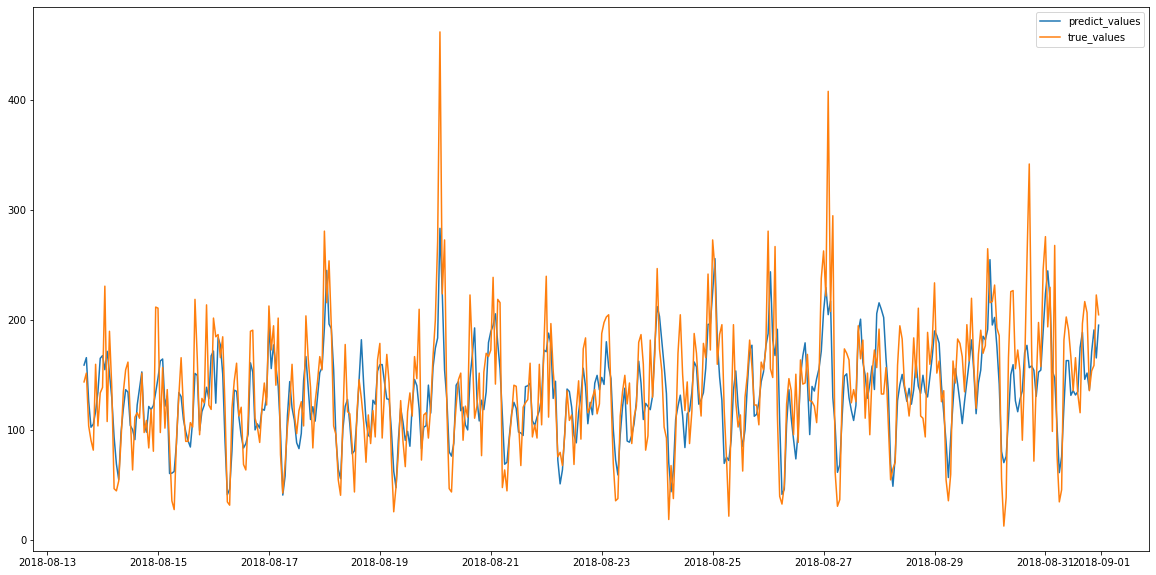

In [29]:
plt.figure(figsize=(20,10))
plt.plot(predictions, label='predict_values')
plt.plot(target_test, label='true_values')
plt.legend();

На данном графике можем увидеть, что модель неплохо предсказывает количество заказов в обычных условиях, однако во время пикового спроса на услуги такси модель не очень хорошо справляется с предсказанием количества заказов, несколько занижая количество предсказанных поездок.

Тем не менее CatBoost обеспечивает приемлемую точность предсказания, установленную условиями проекта: RMSE CatBoost на тестовой выборке - 47.60 при требуемом уровне не более 48.

Проверим модель на адекватность. Для этого сравним её с константной моделью. Для задач регрессии константная модель предсказывает медианное значение количества заказов. При этом медиану будем считать на тренировочной выборке, имитируя процесс обучения. 

In [30]:
predictions_median = pd.Series(target_train.median(), index=target_test.index)
print('RMSE на отложенной выборке для константной модели:', round(mse(target_test, predictions_median, squared=False), 6))

RMSE на отложенной выборке для константной модели: 87.210938


Посмотрим на качество модели, которая будет предсказывать предыдущее значение ряда.

Для этого сместим временной ряд из тестовой выборки на 1 шаг, а 1 его значение, которое станет пропущенным, заменим на последнее значение ряда из тренировочной выборки.

In [31]:
predictions_shift = target_test.shift()
predictions_shift.iloc[0] = target_train.iloc[-1]

Посчитаем RMSE.

In [32]:
print('RMSE на отложенной выборке для наивной модели:', round(mse(target_test, predictions_shift, squared=False), 6))

RMSE на отложенной выборке для наивной модели: 58.881777


Видим, что наша модель CatBoost предсказывает количество поездок существенно лучше константной и наивной модели, из чего делаем вывод, что построенная модель является адекватной.

Таким образом, компании "Чётенькое такси" можно рекомендовать использовать CatBoost для предсказания количества поездок.

# Вывод по этапу 3. 

На данном этапе мы протестировали модели LinearRegression, CatBoost, LightGBM и RandomForest: для моделей (кроме моделей LinearRegression и CatBoost) были подобраны оптимальные гиперпараметры с помощью алгоритма GridSearchCV, качество моделей было оценено на тестовой выборке с помощью метрики RMSE. 

Результаты:

1. LinearRegression: RMSE = 54.34 заказа;
2. CatBoost: RMSE =  47.60 заказов;
3. LightGBM: RMSE = 50.06 заказов;
3. RandomForest: RMSE = 52.29 заказов.

Только модель CatBoost смогла обеспечить требуемый уровень точности предсказания количества заказов. Данная модель была сравнена с константной и наивной моделями и прошла проверку на адекватность. При анализе разницы между реальными значениями временного ряда из тестовой выборки и предсказанными моделью значениями было выявлено, что модель неплохо предсказывает количество поездок в нормальное время, однако в пиковые часы предсказывает количество поездок недостаточно точно, несколько занижая их количество.

# Итоговый вывод по проекту.

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Проект выполнялся в следующем порядке:

1. Импорт библиотек, считывание и первичный анализ данных.

2. Анализ данных, подготовка новых признаков.

3. Обучение и тестирование моделей, подбор гиперпараметров.

Отметим основные выводы.

# Вывод по этапу 1.

На данном этапе были импортированы необходимые библиотеки, а также считан и проанализирован первичный набор данных.

Набор данных представляет собой временной ряд, который описывает количество заказов такси с 2018-03-01 по 2018-08-31 с десятиминутным интервалом. 

Пропущенные и аномальные значения, а также дубликаты не выявлены.

# Вывод по этапу 2.

На данном этапе мы проанализировали временной ряд и создали новые признаки.

Была осуществлена проверка упорядоченности индексов (дат) по возрастанию, визуализирован временной ряд, применена техника скользящего среднего с размером окна от 1 до 25 для сглаживания временного ряда, разложение временного ряда на компоненты (тренд, сезон, ошибка), а также сгенерированы новые признаки: год, месяц, день и день недели на дату измерения количества заказов, значения количества заказов при сдвиге на величину лага, а также скользящее среднее и скользящее стандартное отклонение временного ряда. 

В ходе анализа удалось отметить, что временной ряд демонстрирует явную тенденцию к увеличению количества заказов, имея при этом суточную сезонность: пиковое время, когда заказов больше всего - промежуток с 6 утра до 10-11 утра и с 6 вечера до 1-2 ночи. Напротив, наименее продуктивным временем считается промежуток с 2 часов ночи до 6 часов утра.

# Вывод по этапу 3. 

На данном этапе мы протестировали модели LinearRegression, CatBoost, LightGBM и RandomForest: для моделей (кроме моделей LinearRegression и CatBoost) были подобраны оптимальные гиперпараметры с помощью алгоритма GridSearchCV, качество моделей было оценено на тестовой выборке с помощью метрики RMSE. 

Результаты:

1. LinearRegression: RMSE = 54.34 заказа;
2. CatBoost: RMSE =  47.60 заказов;
3. LightGBM: RMSE = 50.06 заказов;
3. RandomForest: RMSE = 52.29 заказов.

Только модель CatBoost смогла обеспечить требуемый уровень точности предсказания количества заказов. Данная модель была сравнена с константной и наивной моделями и прошла проверку на адекватность. При анализе разницы между реальными значениями временного ряда из тестовой выборки и предсказанными моделью значениями было выявлено, что модель неплохо предсказывает количество поездок в нормальное время, однако в пиковые часы предсказывает количество поездок недостаточно точно, несколько занижая их количество.